In [1]:

from importlib import reload
import random
import torch
import os
import numpy as np
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
import pickle

import trainer
reload(trainer)

import mcts.networks
reload(mcts.networks)

import augmentor
reload(augmentor)

from trainer import PatternTrainer
from mcts.networks import PatternsNet
from plotting import PatternPlotter
from augmentor import StateAugmentor

my_device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# rseed = 12387623
# random.seed(rseed)
# torch.manual_seed(rseed)
# np.random.seed(rseed)


In [ ]:
### get saved game files in location:

# _lstrings = [
#     '2025_07_01_23_03',
#     '2025_07_01_23_23',
#             ]

load_dir = os.path.join(Path.cwd(), 'saved_games', 'v4', 'train')
saved_games = os.listdir(load_dir)
rgame = random.choice(saved_games)
_games = pickle.load(open(os.path.join(load_dir, rgame), 'rb'))
# saved_games = pickle.load(open(load_string, 'rb'))
# len(saved_games[-1]), len(saved_games[0]), len(saved_games[1])

In [ ]:
### get saved game files in location:

load_dir = os.path.join(Path.cwd(), 'saved_games', 'search_v1')
saved_games = os.listdir(load_dir)
rgame = random.choice(saved_games)
_games = pickle.load(open(os.path.join(load_dir, rgame), 'rb'))


In [ ]:
g1, g2, g3 = _games[1][999], _games[1][1000], _games[1][1001]





In [ ]:
g2[0][24:30, 0, 0]

In [ ]:
new_games = []
for game in [g1, g2, g3]:
    paug = StateAugmentor(game[0])
    new_game = paug.create_game_from_state()
    pplotter = PatternPlotter(new_game)
    pplotter.plot()
    print(new_game.calculate_score())
    new_games.append(new_game)

In [ ]:
from int_to_board import loci, locj

In [ ]:
game = copy.deepcopy(new_games[2])
action = 18

board = np.array(game.passive_board)

active_token = game.passive_bowl_token
passive_token = game.active_bowl_token

print(active_token, passive_token)

# active and passive reversed to represent the swap in players after action:
active_order = game.passive_color_order[:]
passive_order = game.active_color_order[:]

print(active_order, passive_order)

# also get the color groups:
active_color_groups = {_key: _val[:] for _key, _val in game.passive_color_groups.items()}
passive_color_groups = {_key: _val[:] for _key, _val in game.active_color_groups.items()}

print(active_color_groups, passive_color_groups)

# remaining actions represent a change to the board state:
location = action % 52
coords = loci[location], locj[location]

# update the relevant color group with the coordinates of the flipped location:
cg_update_color = passive_token if action < 52 else board[coords]
passive_color_groups[cg_update_color].append(coords)

print(cg_update_color, passive_color_groups)

# the passive token becomes the color at the location, the new location gets the COLOR of the passive token:
if action < 52:
    new_token = board[coords]
    board[coords] = passive_token
    passive_token = new_token

# Whether flipping or placing, the location takes on the +12 of the passive player:
board[coords] += 12

# only the passive order can be updated...
if not game.active_color_groups[game.active_bowl_token]:
    passive_order[game.active_bowl_token] = game.active_placing_number

print(passive_order)

In [ ]:
board, aorder, porder, atoken, ptoken, place_bool, acolgroups, pcolgroups = (board, active_order, passive_order, active_token, passive_token, game.is_no_more_placing, active_color_groups, passive_color_groups)

# the board is just a one hot encoded version of the numpy board. value 18 (19th class) is board corners.
board_tensor = torch.nn.functional.one_hot(
    torch.tensor(board).long(), num_classes=19)[:, :, :-1]

# 36 channels for each player for color group: order mapping:
order_tensor = torch.zeros((8, 8, 12), dtype=torch.float)
order_values = torch.tensor(aorder + porder, dtype=torch.float) / 6.0 # normalize to between 0.0 and 1.0:
order_tensor[:, :, range(12)] = order_values

# bowl tokens: 12 additional channels.
bowl_tensor = torch.zeros((8, 8, 12), dtype=torch.bool)
bowl_tensor[:, :, atoken] = 1
bowl_tensor[:, :, 6 + ptoken] = 1

# is no more placing:
placing_tensor = torch.ones((8, 8, 1), dtype=torch.bool) if place_bool else torch.zeros((8, 8, 1), dtype=torch.bool)

# also capture the current score:
score_tensor = torch.zeros((8, 8, 2), dtype=torch.float)
active_score = 0
passive_score = 0

for _col, (_aorder, _porder) in enumerate(zip(aorder, porder)):
    active_score += len(acolgroups[_col]) * _aorder
    passive_score += len(pcolgroups[_col]) * _porder

score_tensor[:, :, 0] = active_score / 150.
score_tensor[:, :, 1] = passive_score / 150.

# additional redundant information that may help: the current value of the token in hand:
token_value_tensor = torch.zeros((8, 8, 2), dtype=torch.float)

# determine the placing numbers:
apnum, ppnum = 1, 1
for _col, (_a, _p) in enumerate(zip(aorder, porder)):
    # increment for each time a color has been taken:
    if _a > 0:
        apnum += 1

    if _p > 0:
        ppnum += 1

active_value = aorder[atoken] if aorder[atoken] != 0 else apnum
passive_value = porder[ptoken] if porder[ptoken] != 0 else ppnum

token_value_tensor[:, :, 0] = active_value / 6.0
token_value_tensor[:, :, 1] = passive_value / 6.0

# stack the three tensors together:
concat_tensor = torch.cat([board_tensor, order_tensor, bowl_tensor, placing_tensor, score_tensor,
                           token_value_tensor], dim=-1)

# and put channels first, for CNN:
tensor_state = concat_tensor.permute(2, 0, 1)

In [ ]:
paug = StateAugmentor(tensor_state)
new_game = paug.create_game_from_state()
pplotter = PatternPlotter(new_game)
pplotter.plot()
print(new_game.calculate_score())


In [ ]:
if not game.active_color_groups[game.active_bowl_token]:
    passive_order[game.active_bowl_token] = game.active_placing_number

In [ ]:
passive_color_groups, active_color_groups

In [ ]:
sorted(game.get_actions())

In [ ]:
len(_games[0]), len(_games[1]), len(_games[-1])


In [ ]:
### Testing for the augmentor:

_check = random.choice(_games[-1])

check_tensor = _check[0]
check_visit_counts = _check[1]
check_distance_from_terminal = _check[2]
check_flipped = _check[3]
check_nod_result = _check[4]


where_vcs = np.where(check_visit_counts)
vcs_num = check_visit_counts[where_vcs]

print(f'Original visit counts: {where_vcs}, {vcs_num}')

# use augmentor to create a non-augmented game:
paug = StateAugmentor(check_tensor, check_visit_counts)
recreated_game = paug.create_game_from_state()
paug.full_augment()

where_vcs = np.where(paug.visit_counts)
vcs_num = paug.visit_counts[where_vcs]

aug_game_1 = paug.create_game_from_state()
print(f'Augmented visit counts 1: {where_vcs}, {vcs_num}')

for it in range(5):
    paug.full_augment()

where_vcs = np.where(paug.visit_counts)
vcs_num = paug.visit_counts[where_vcs]

print(f'Augmented visit counts 2: {where_vcs}, {vcs_num}')
aug_game_2 = paug.create_game_from_state()

pplotter_1 = PatternPlotter(recreated_game)
pplotter_2 = PatternPlotter(aug_game_1)
pplotter_3 = PatternPlotter(aug_game_2)

pplotter_1.plot()
pplotter_2.plot()
pplotter_3.plot()
check_nod_result, check_tensor[-10:, 0, 0]

print(aug_game_1.calculate_score(), aug_game_2.calculate_score(), recreated_game.calculate_score())


In [ ]:
### Create a fresh network and assign to a trainer:
big_network = PatternsNet(
    in_channels=47, 
    out_channels=256,
).float()

sum(p.numel() for p in big_network.parameters() if p.requires_grad)

# print([(name, p.dtype) for name, p in my_network.named_parameters()])

In [ ]:
# check the actual res net design and num params for alpha zero and mimic that a bit more.

In [2]:
### Create a fresh network and assign to a trainer if starting again:
my_network = PatternsNet(
    in_channels=47, 
    out_channels=128,
).float()

my_trainer = PatternTrainer(network=my_network,
                            device=my_device)

# sum(p.numel() for p in my_network.parameters() if p.requires_grad)

# print([(name, p.dtype) for name, p in my_network.named_parameters()])


In [ ]:
# todo change this to do actual epoch training using data loaders perhaps.
# In particular, each record should be used each time through.


In [8]:
### load the best existing network in before continuing training:
net_file = '2025_07_11_03_47.pt'
network_directory = os.path.join(Path.cwd(), 'saved_networks', 'v4', net_file)

# create shell networks:
my_network = PatternsNet(in_channels=47, out_channels=128)
my_network.load_state_dict(torch.load(network_directory, weights_only=True))

my_trainer = PatternTrainer(network=my_network,
                            device=my_device)



_epoch=400, _bsize=512, _lr=0.002

2025_07_10_16_43.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_16_58.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_17_14.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_17_29.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_17_45.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_18_00.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_18_15.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_18_31.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_18_47.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_19_03.pkl
Current epoch: 99

Current epoch: 199

Curr

C:\Users\Danie\AppData\Local\Temp\ipykernel_23536\4122952284.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


2025_07_10_18_15.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_18_31.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_18_47.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_19_03.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_19_19.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_19_35.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_19_51.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_20_06.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399

2025_07_10_20_22.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

Current epoch: 399


_epoch=400, _bsize=512, _lr=0.0002

2025_07_10_16_43.pkl
Current epoch: 99

Current epoch: 199

Cur

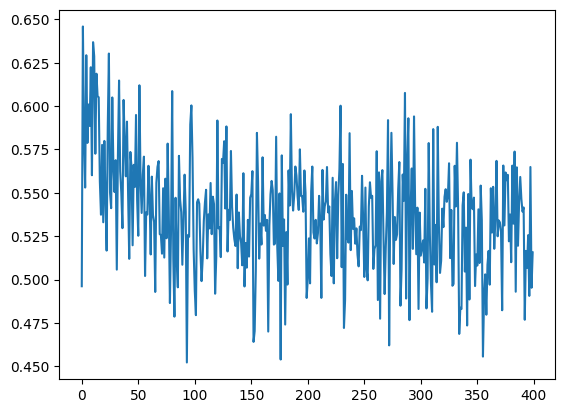

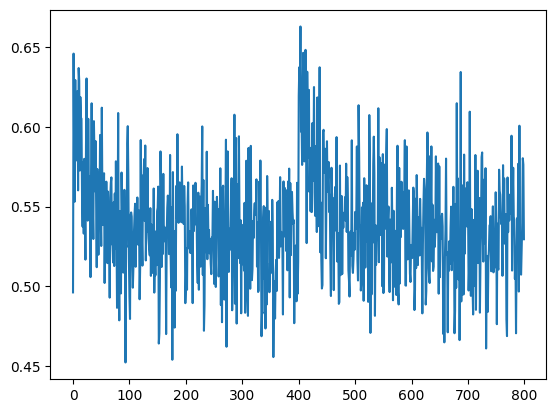

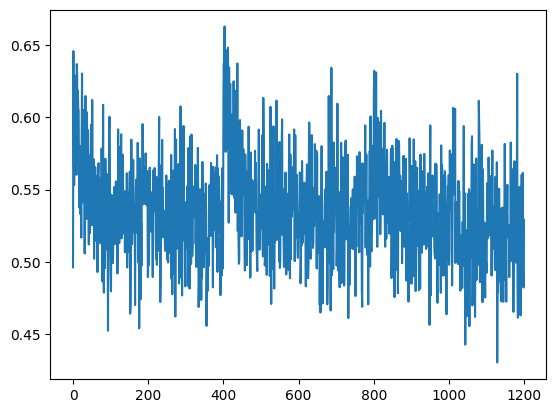

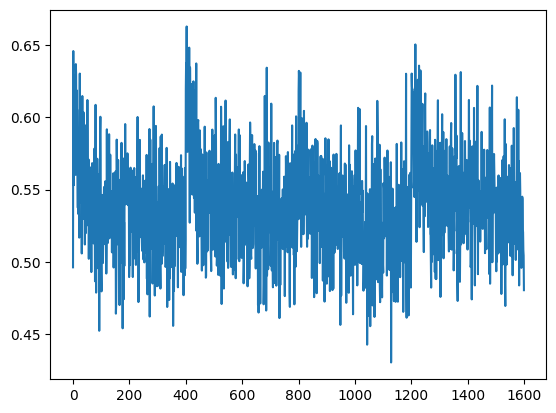

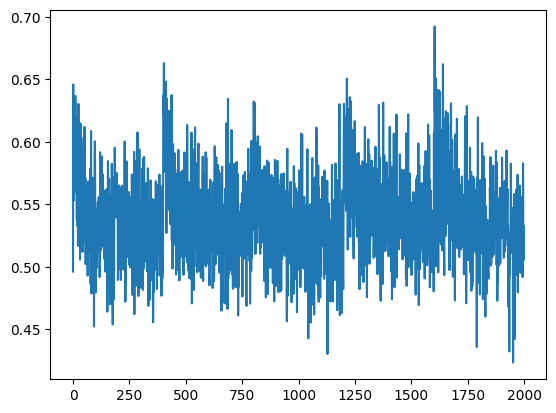

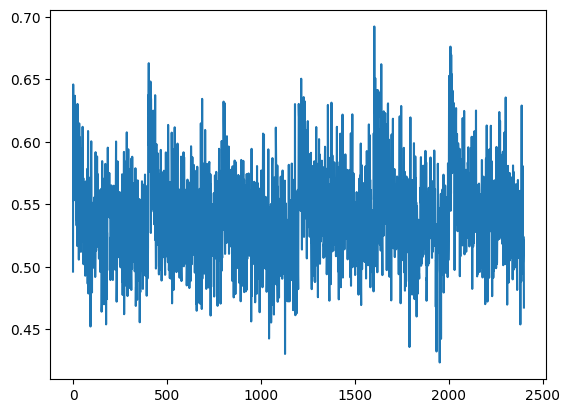

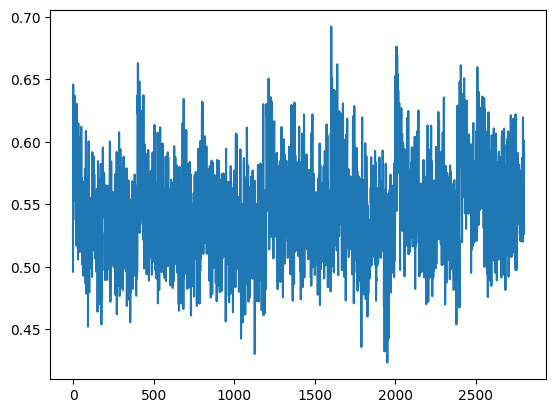

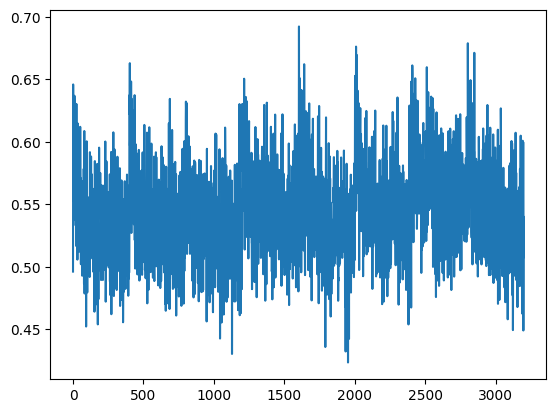

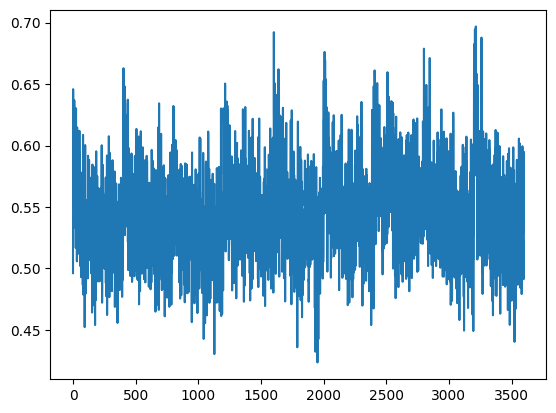

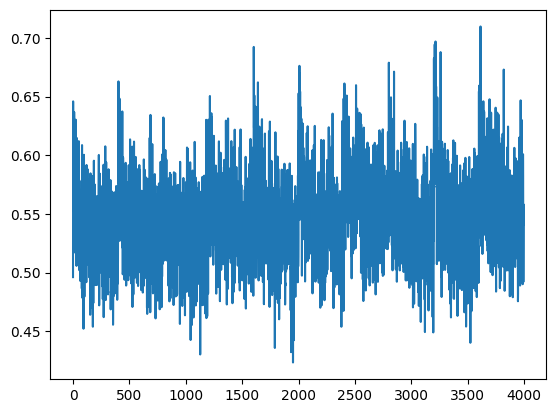

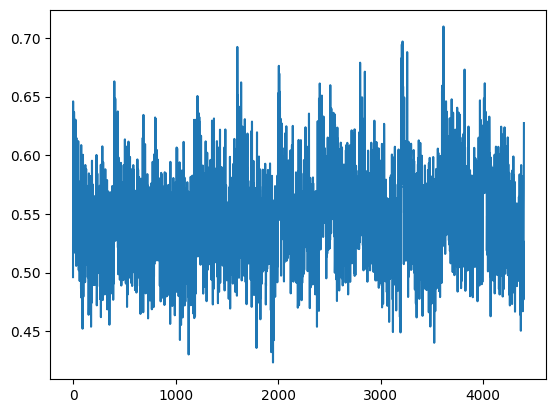

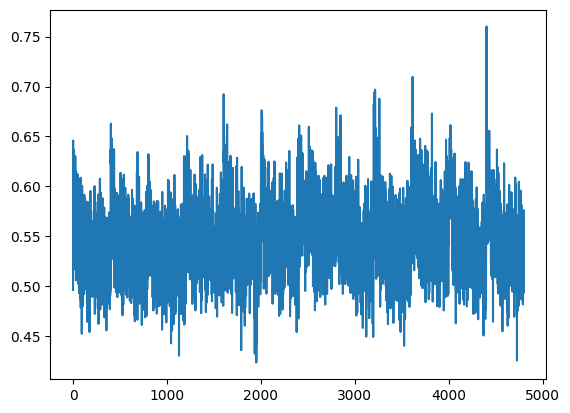

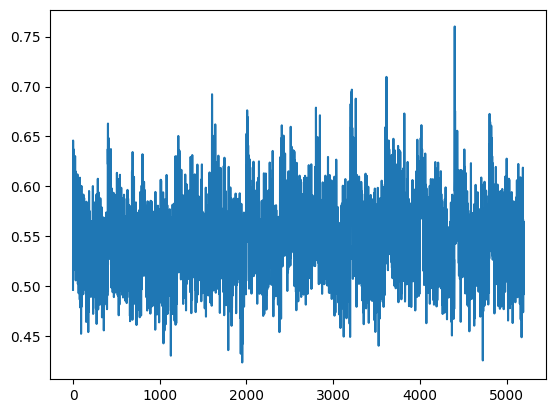

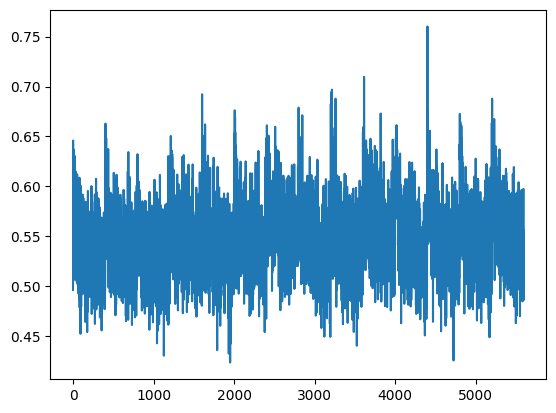

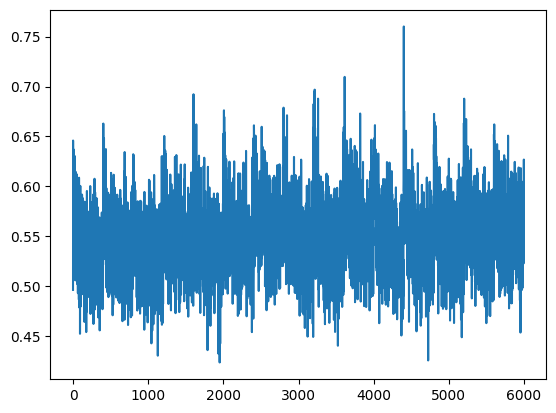

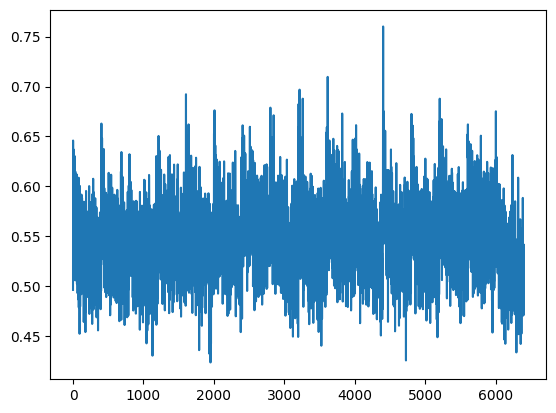

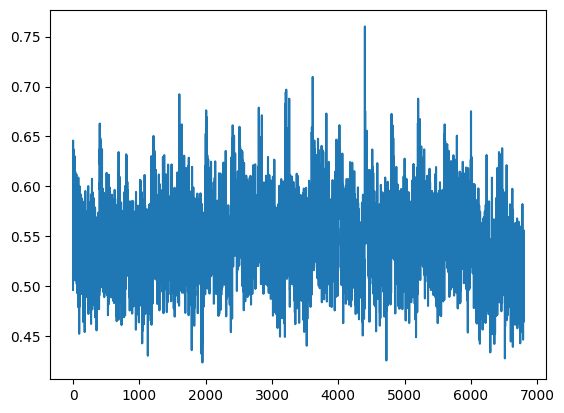

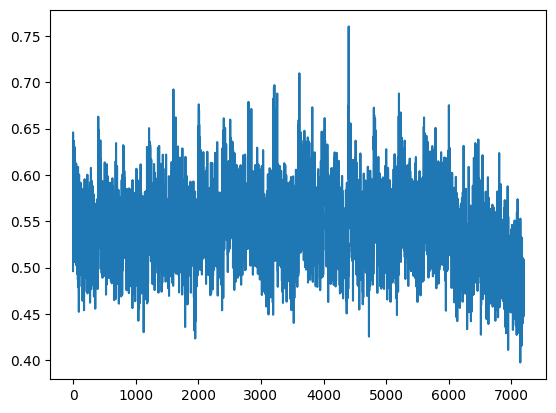

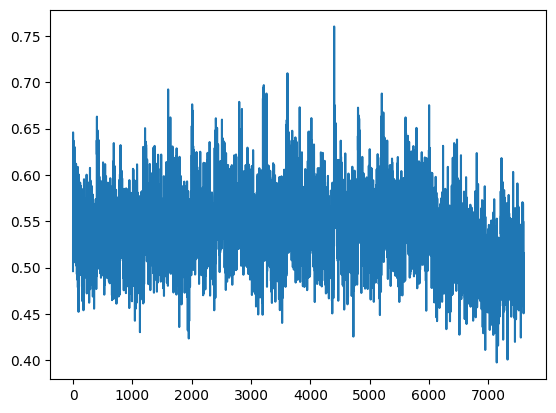

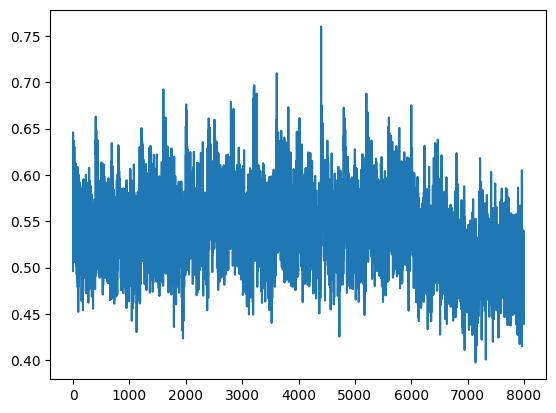

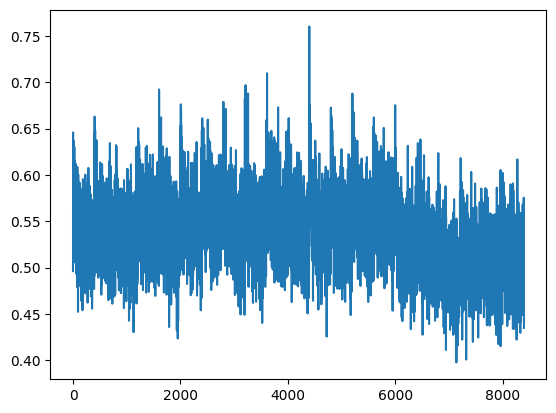

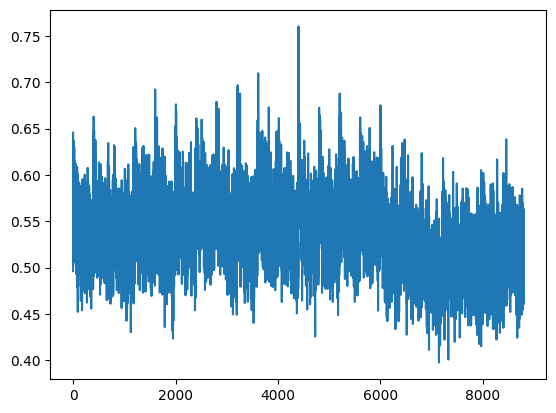

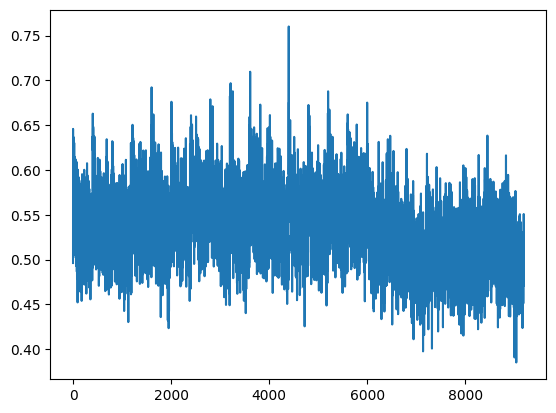

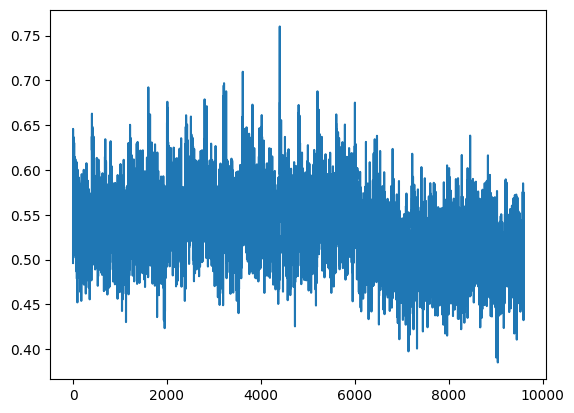

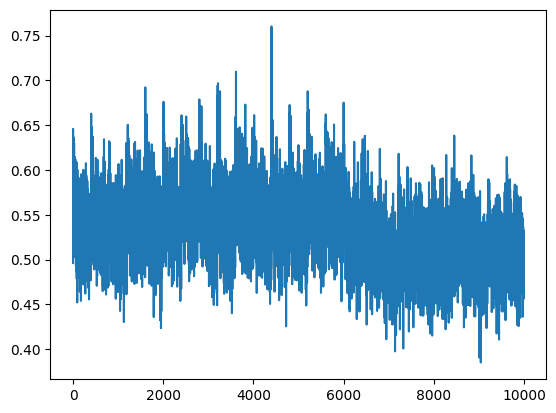

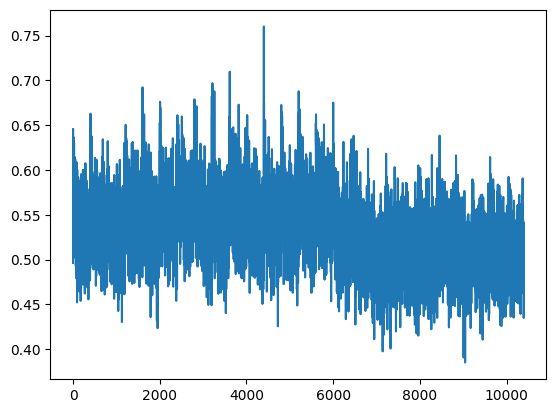

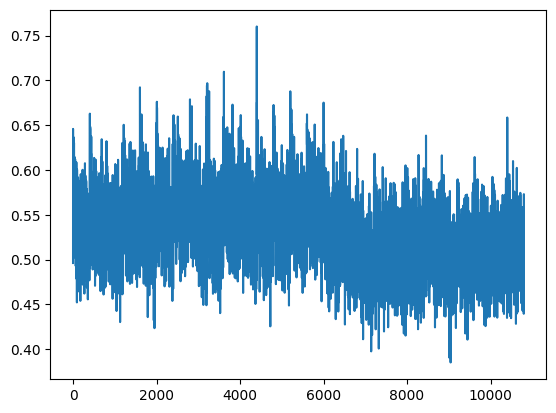

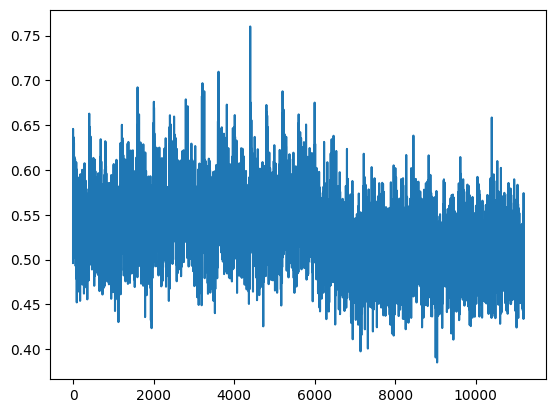

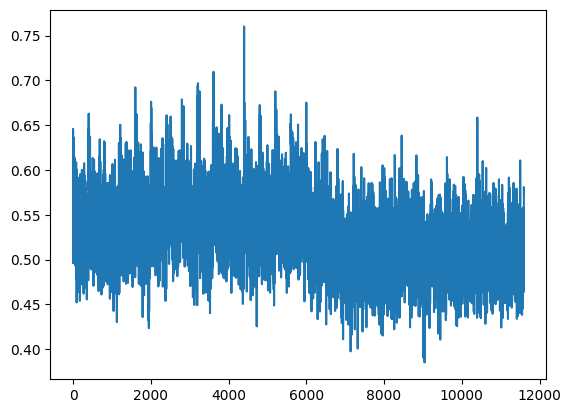

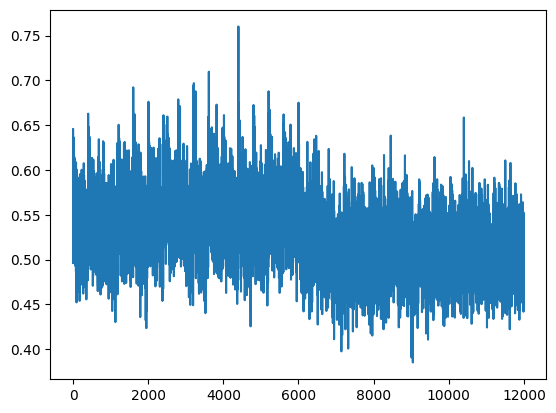

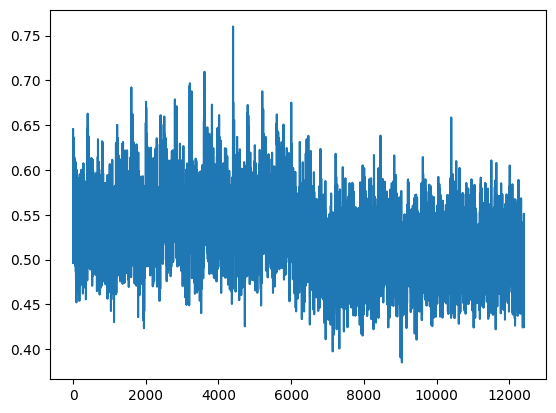

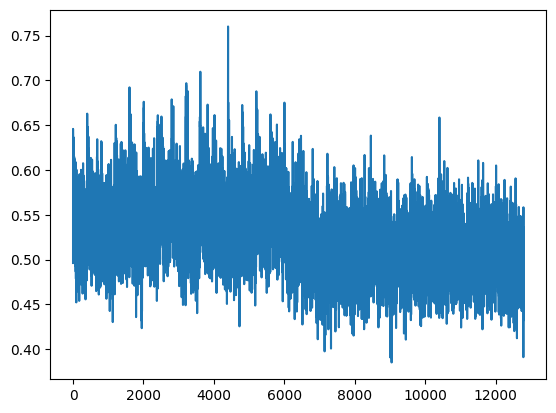

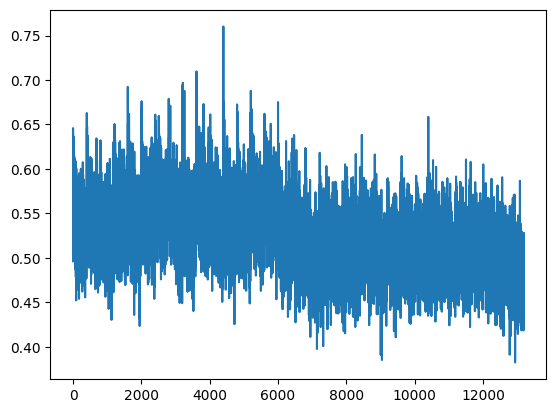

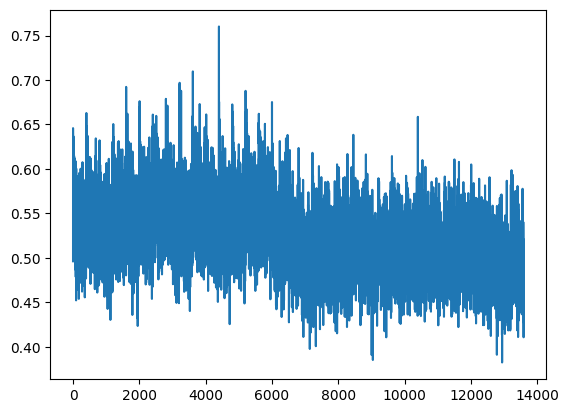

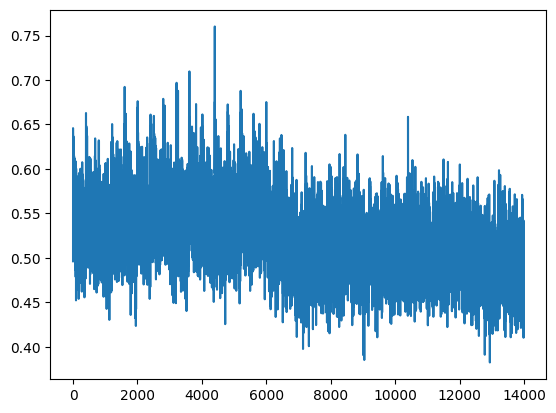

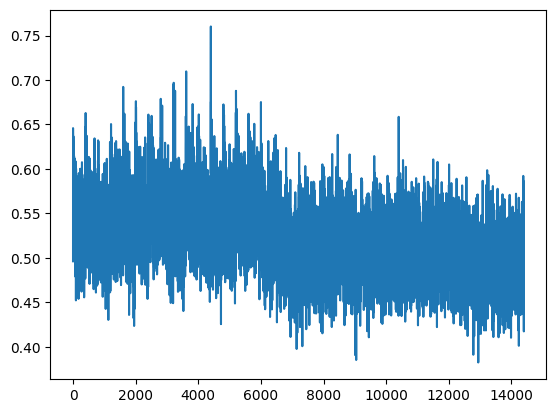

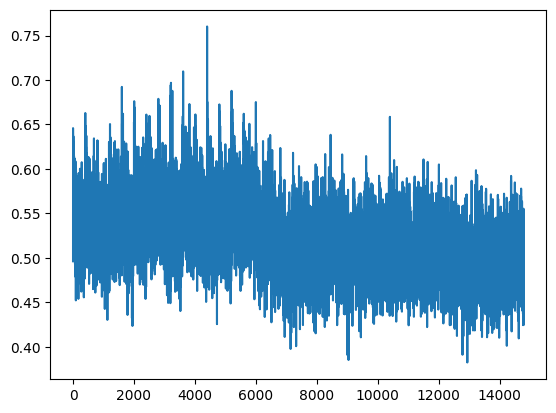

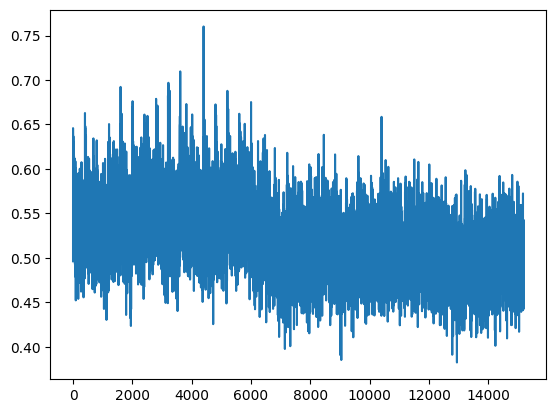

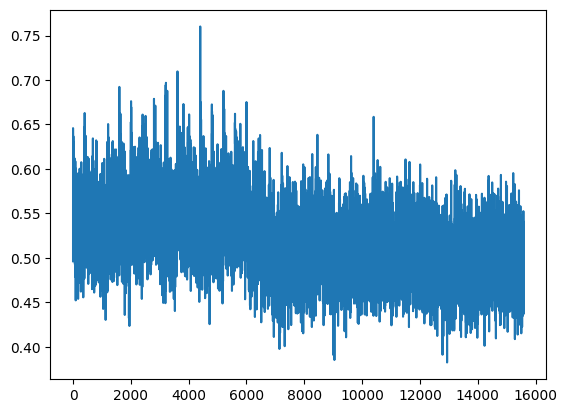

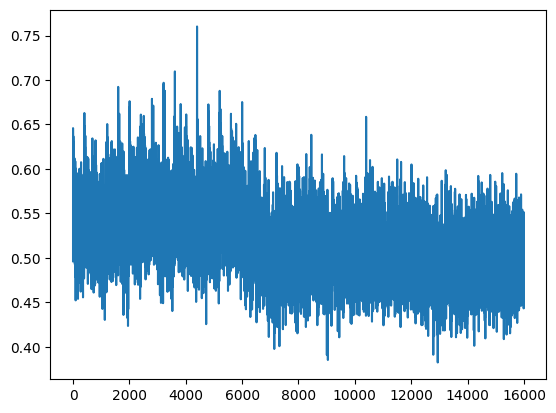

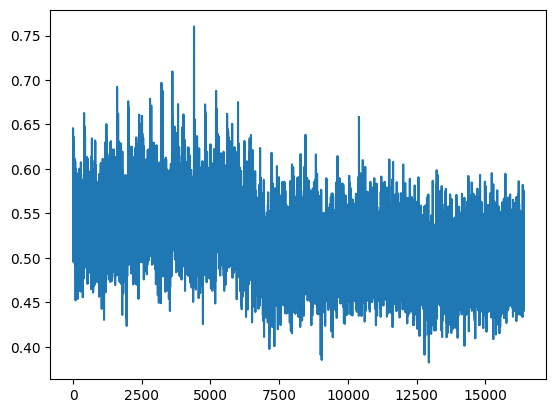

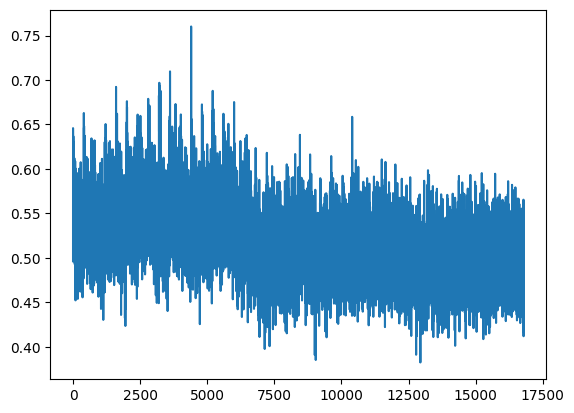

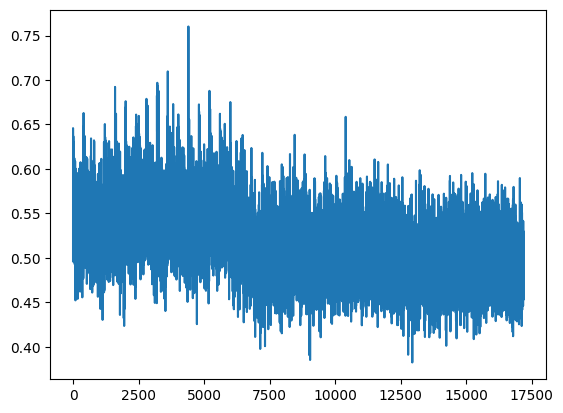

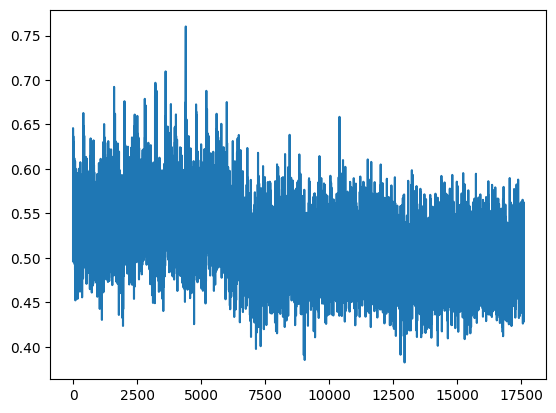

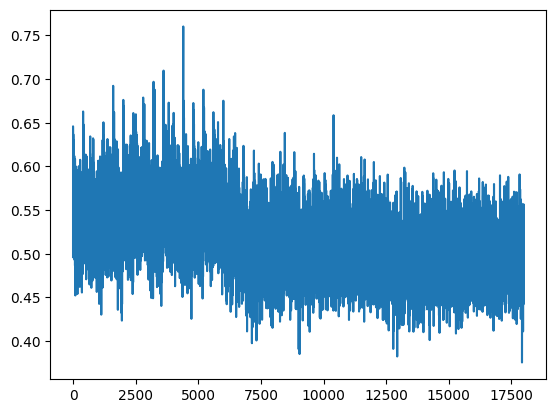

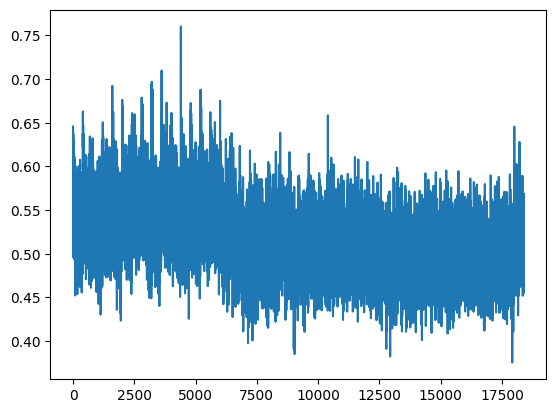

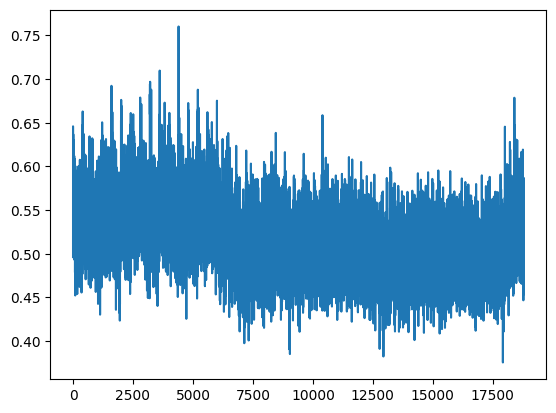

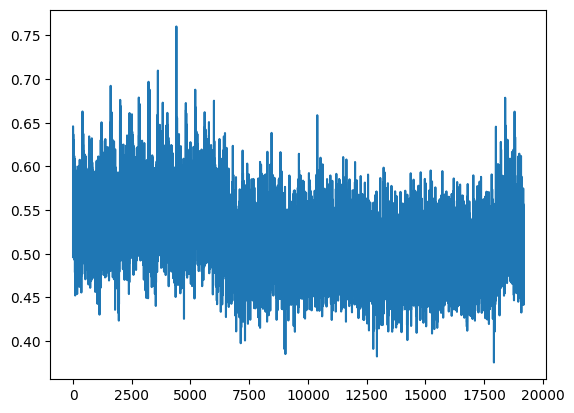

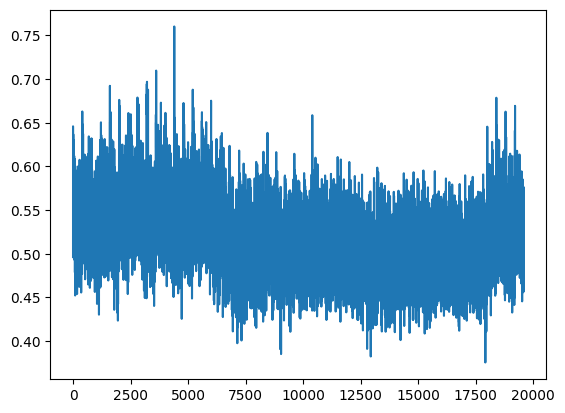

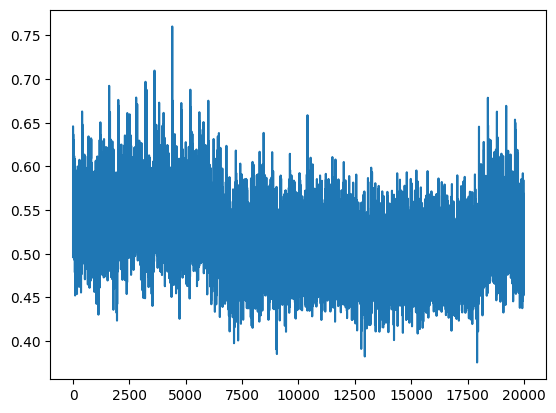

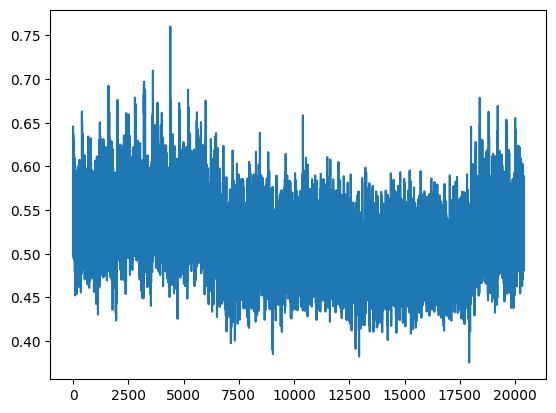

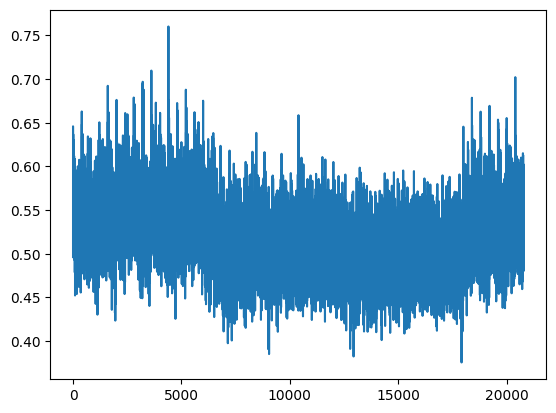

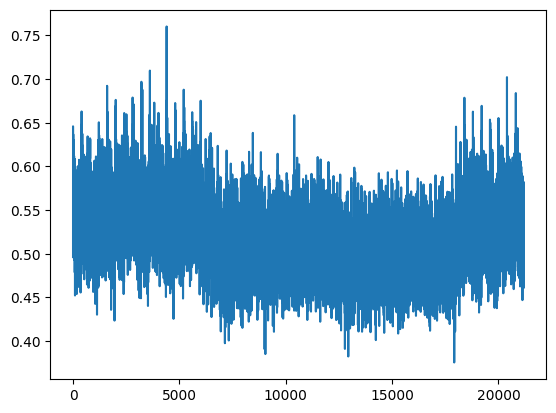

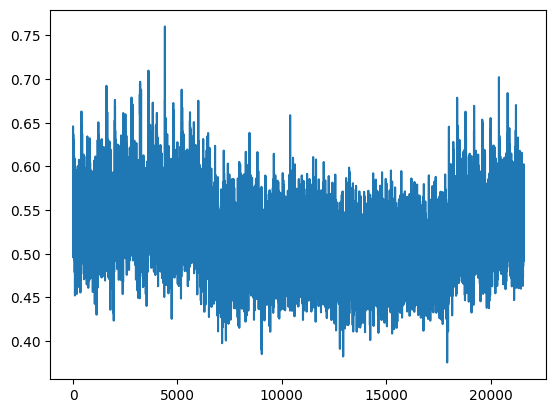

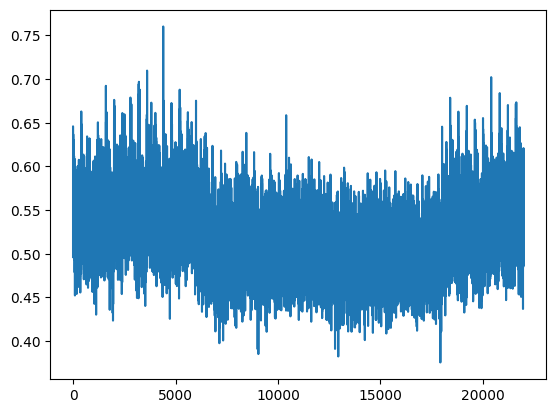

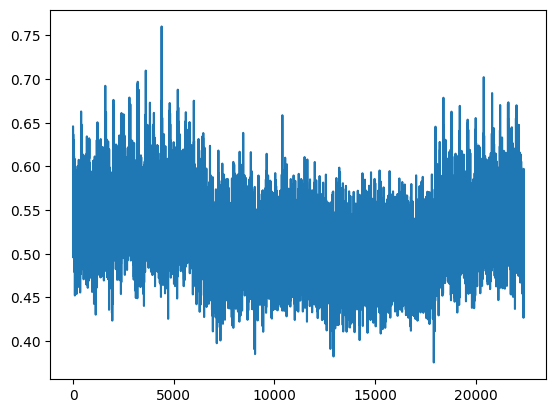

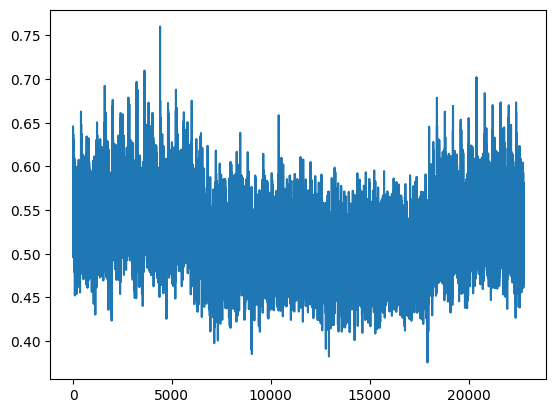

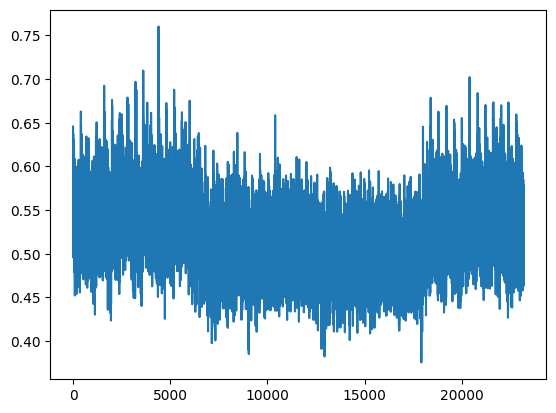

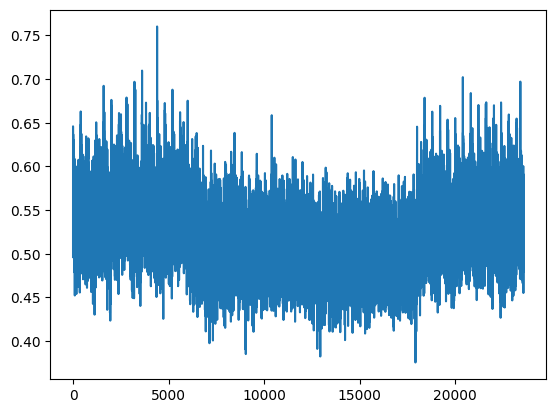

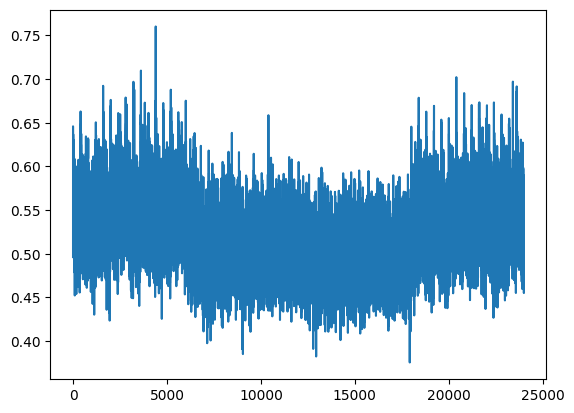

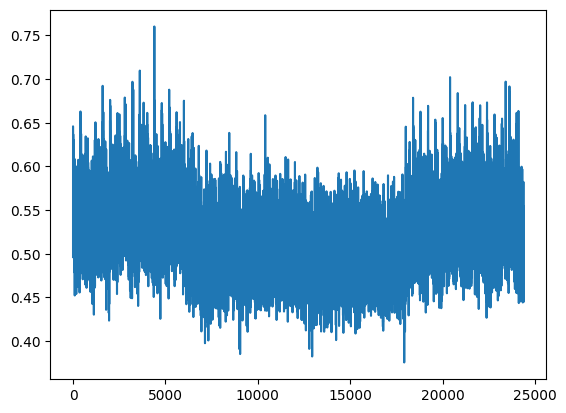

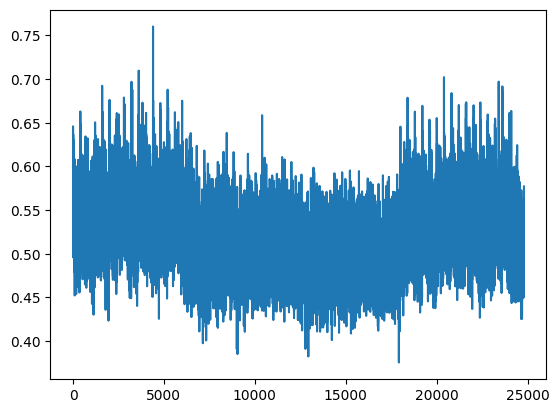

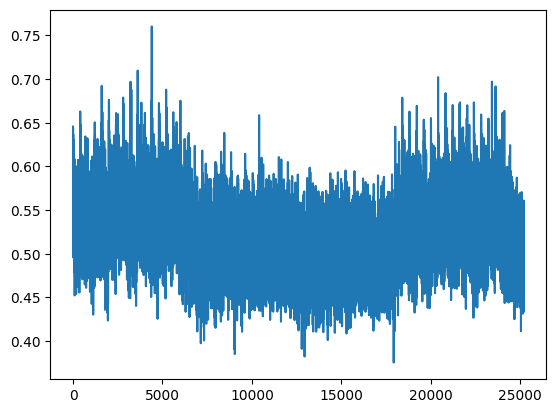

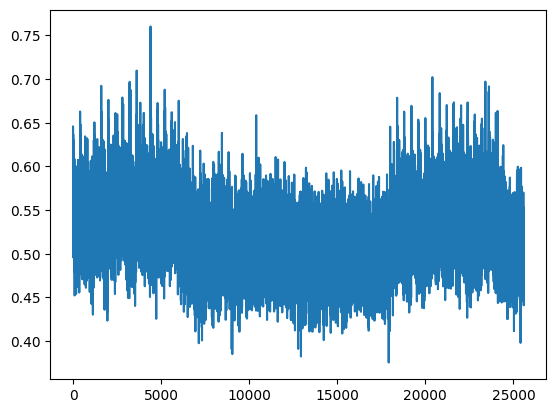

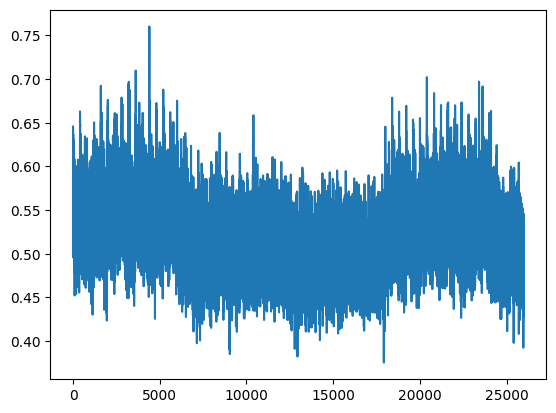

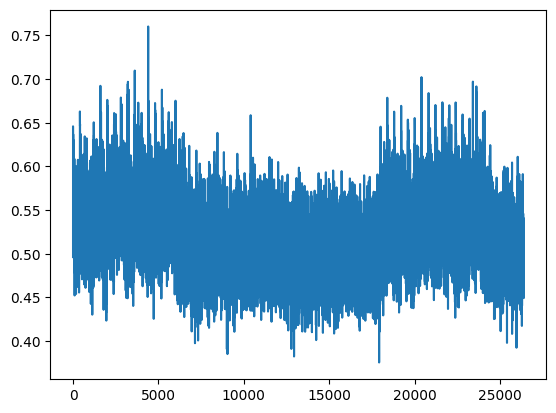

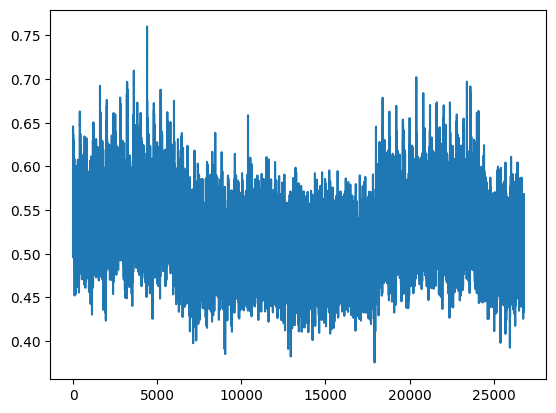

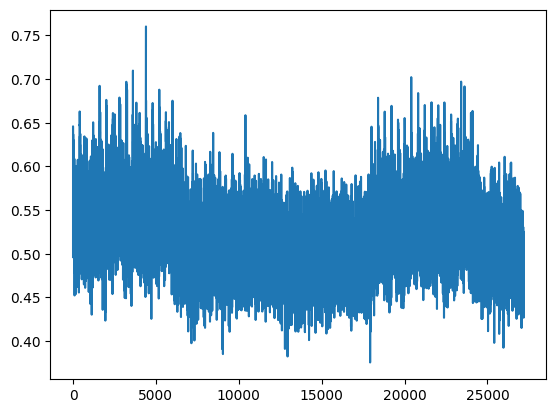

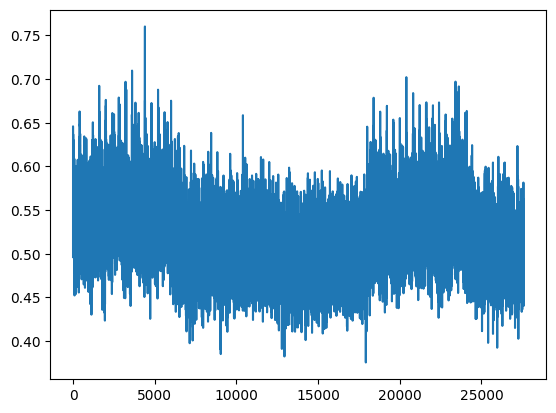

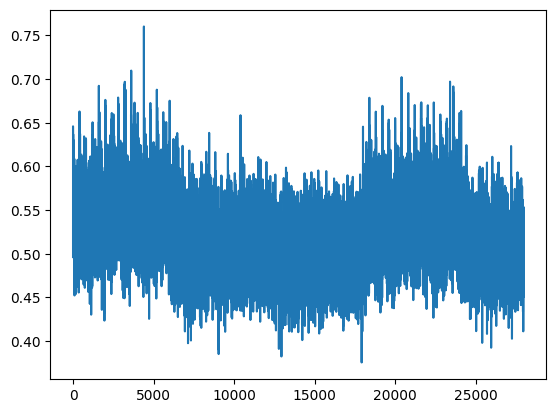

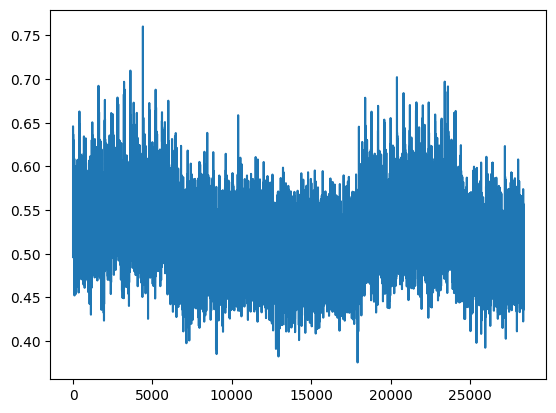

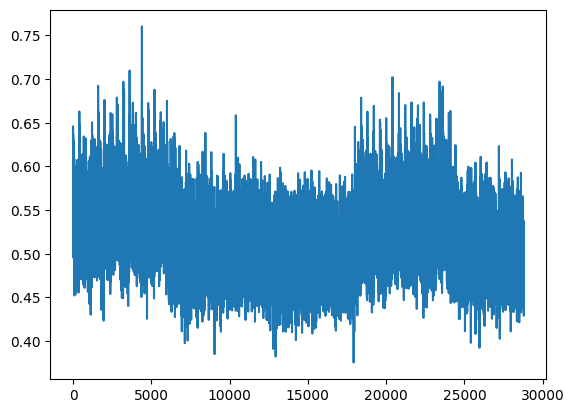

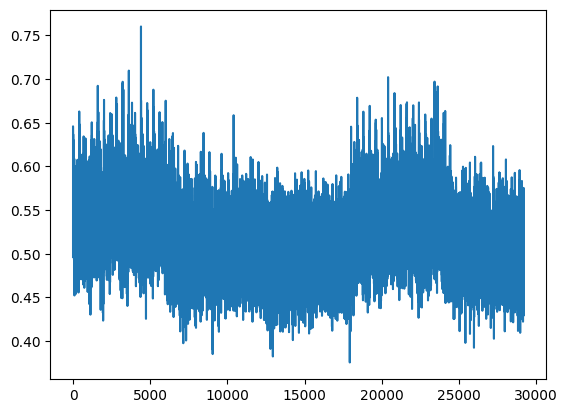

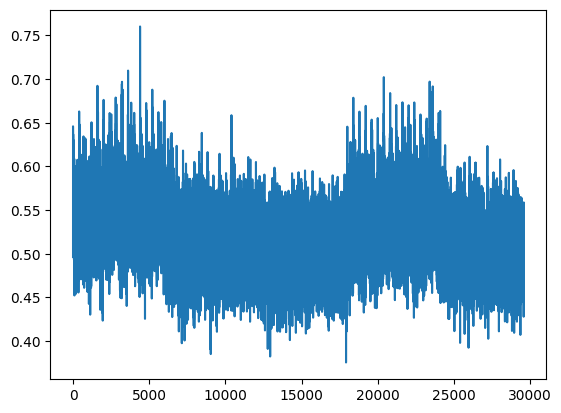

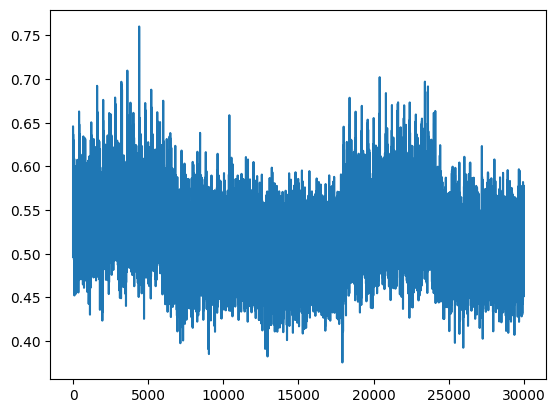

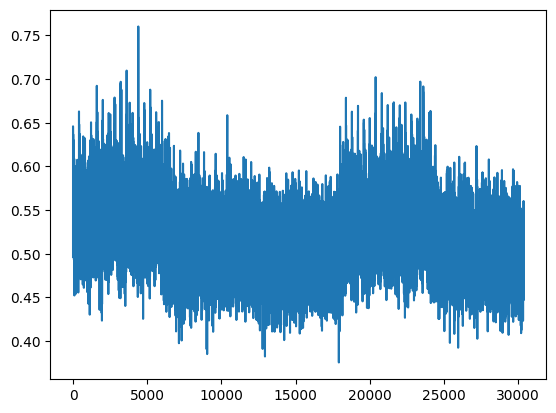

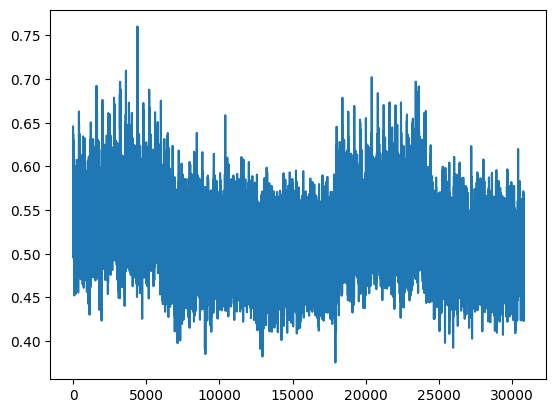

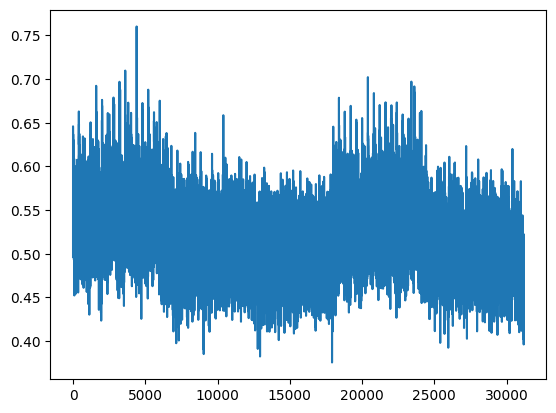

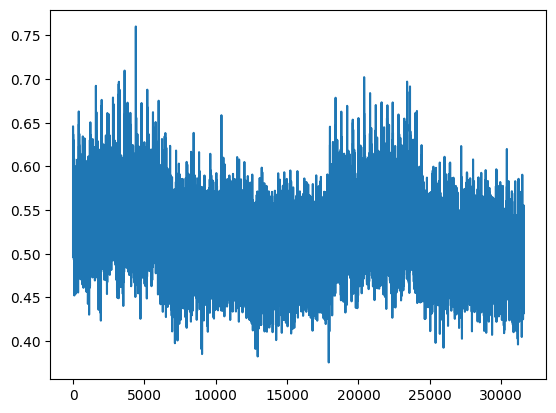

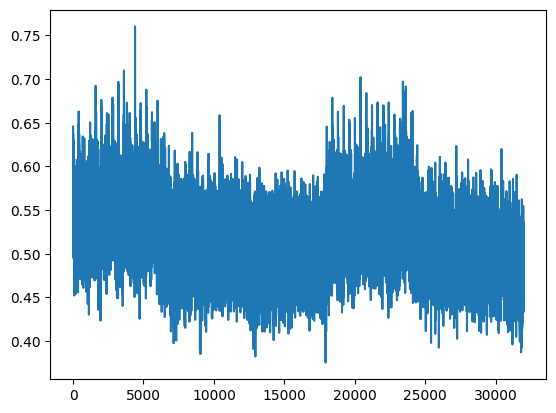

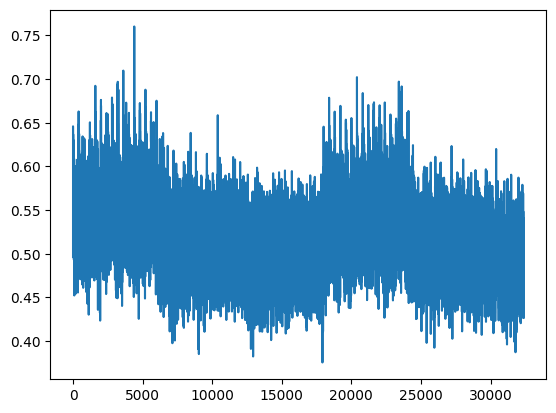

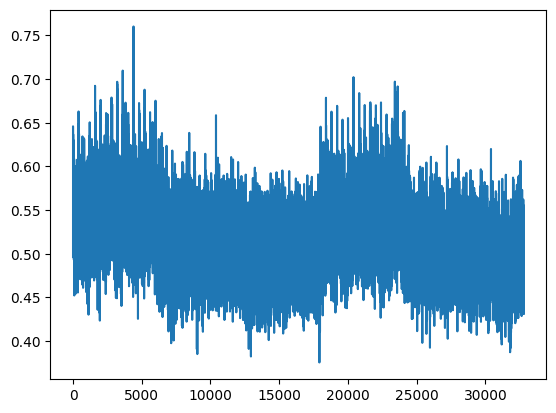

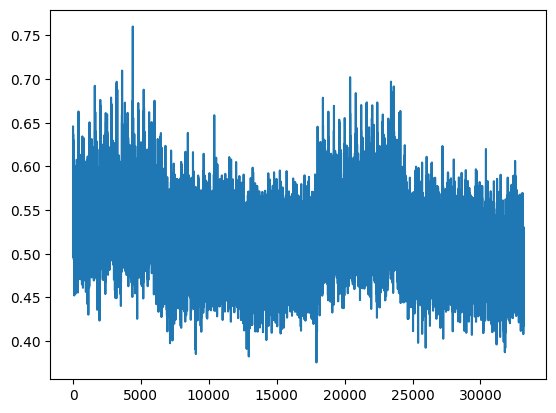

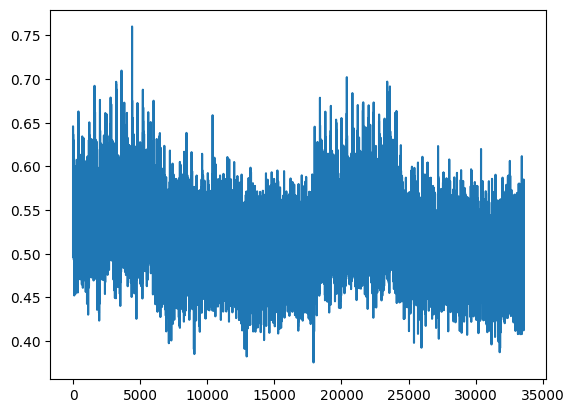

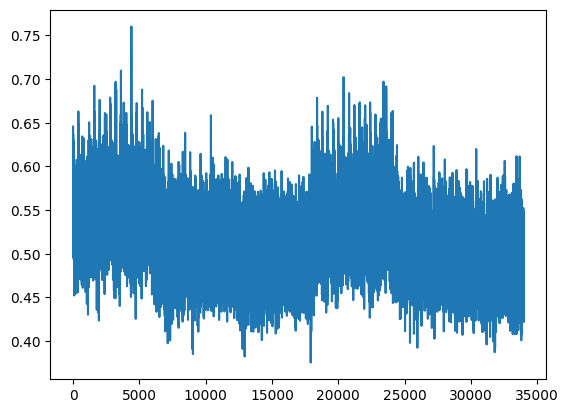

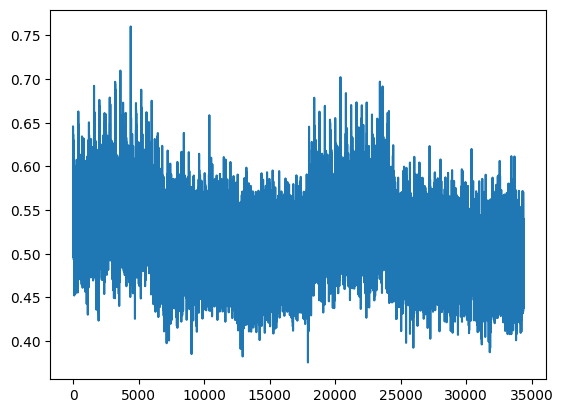

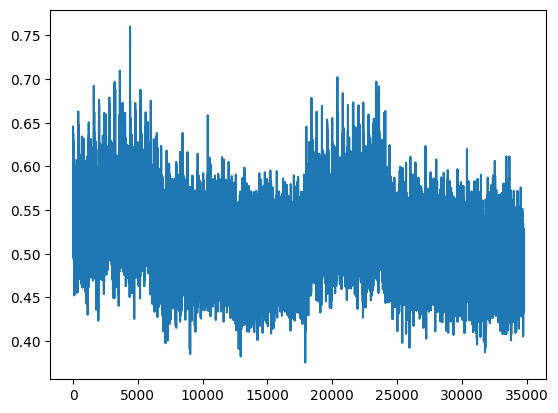

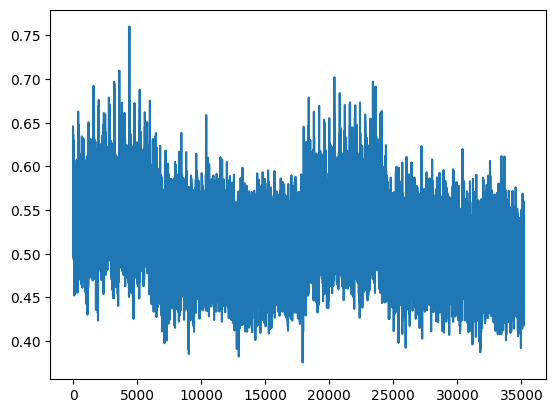

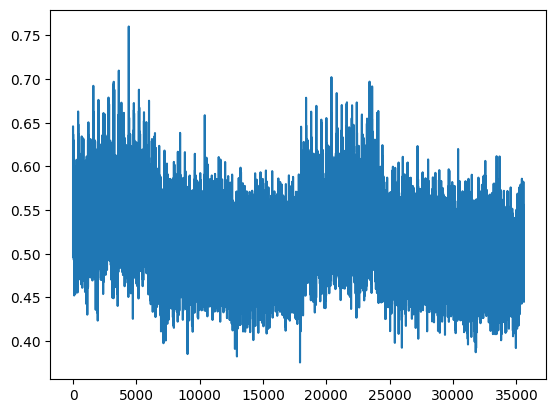

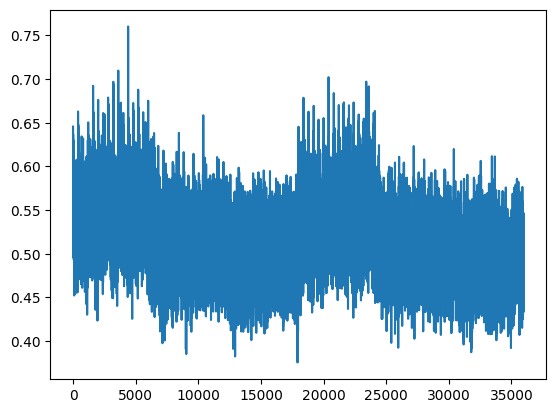

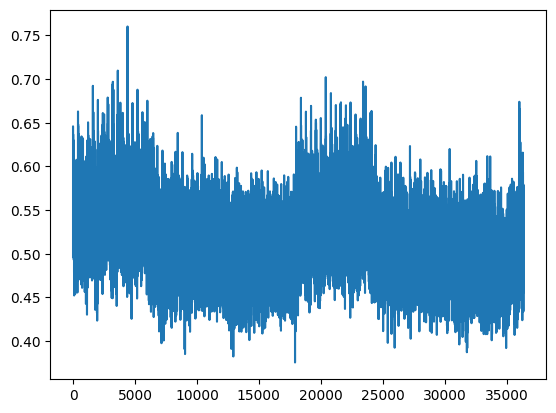

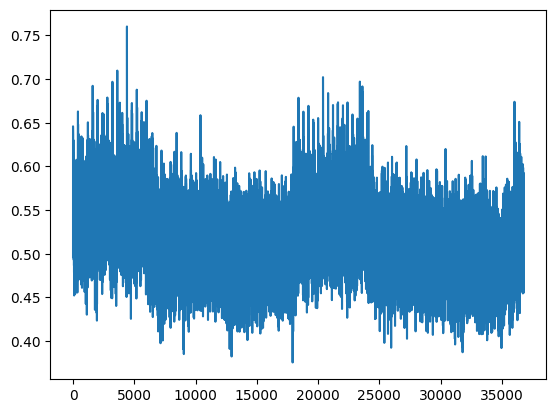

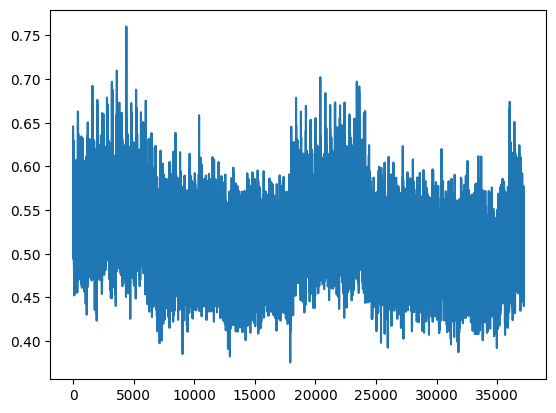

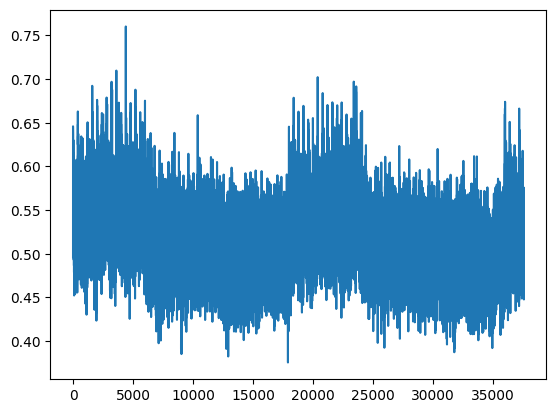

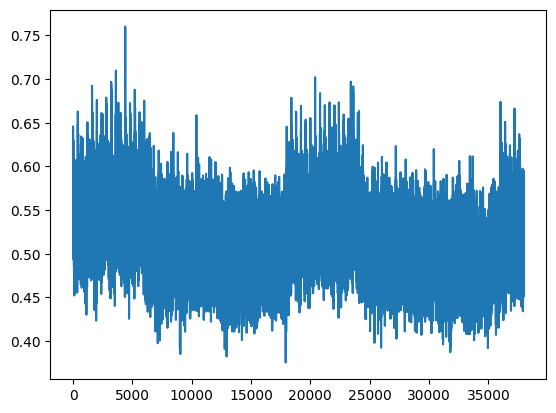

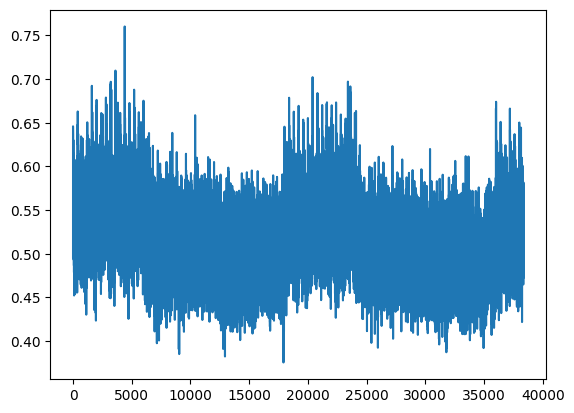

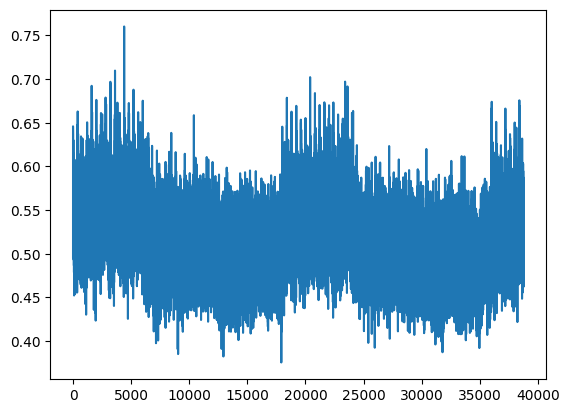

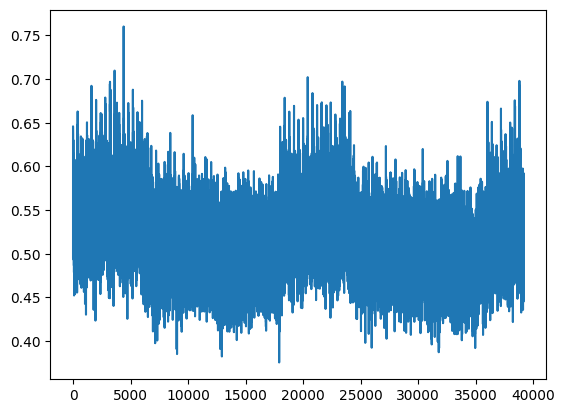

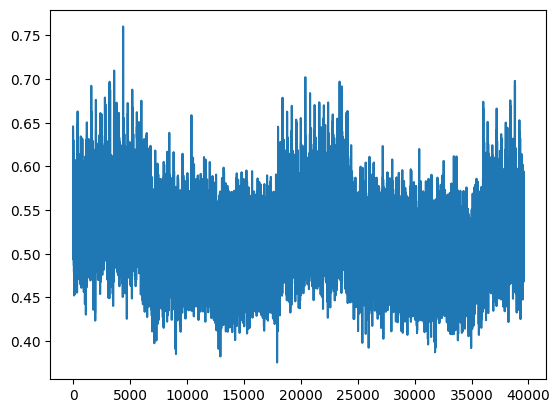

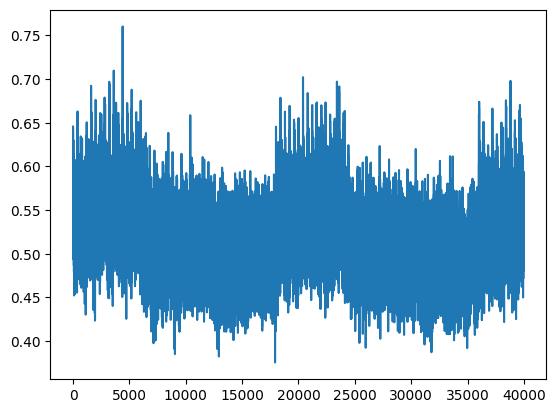

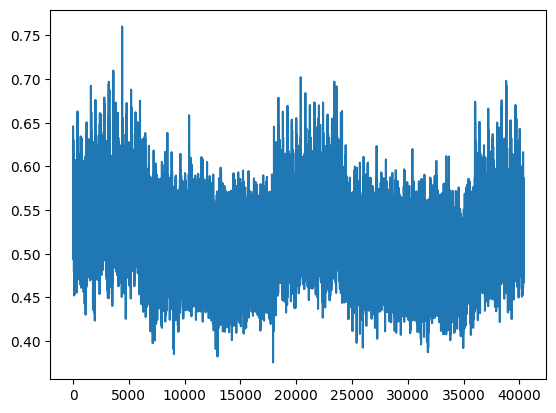

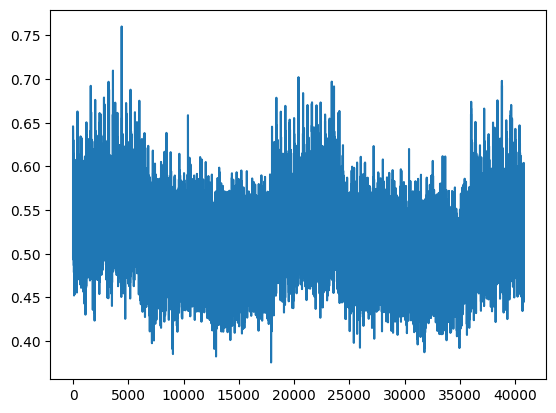

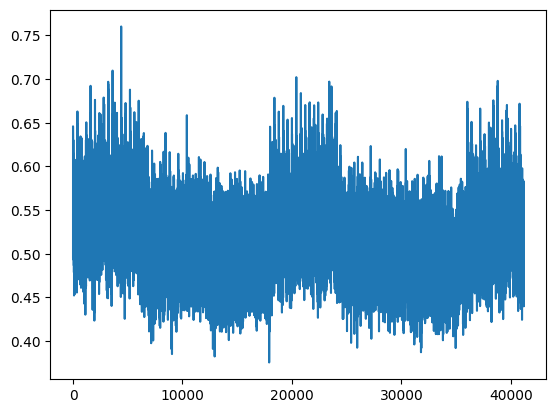

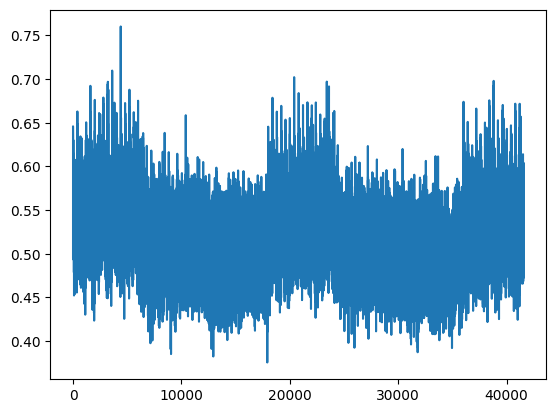

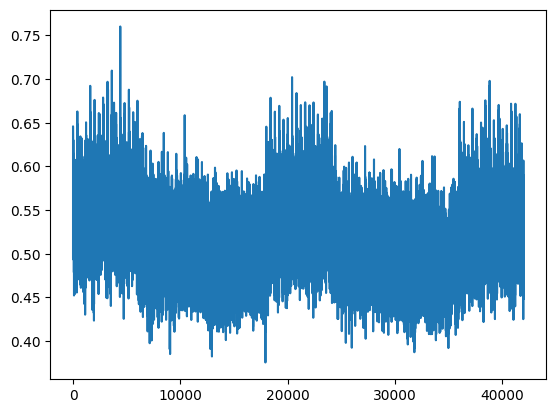

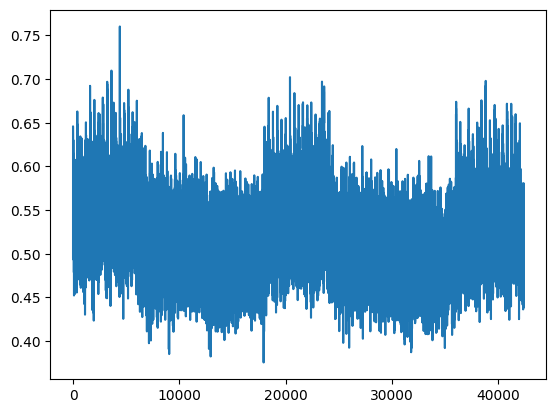

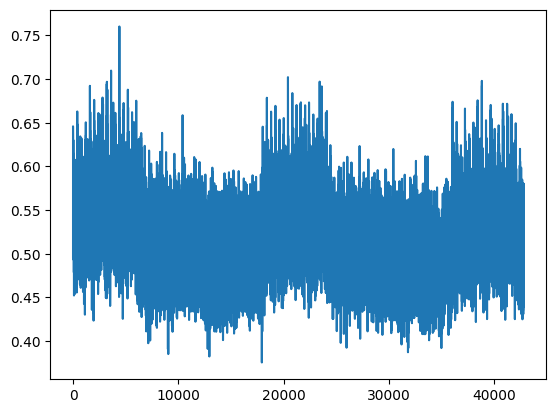

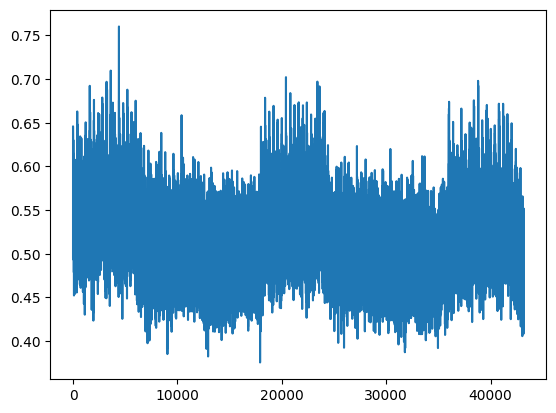

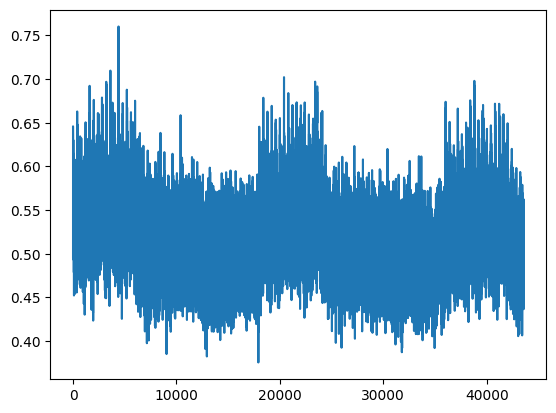

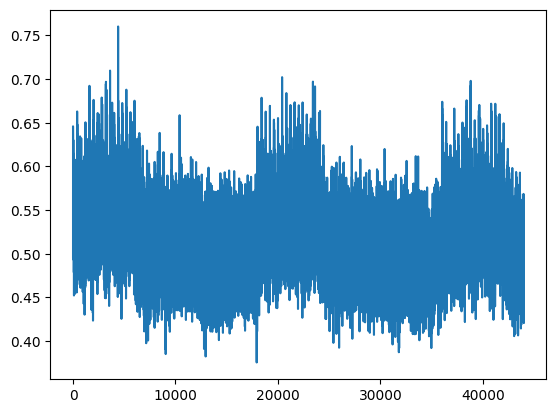

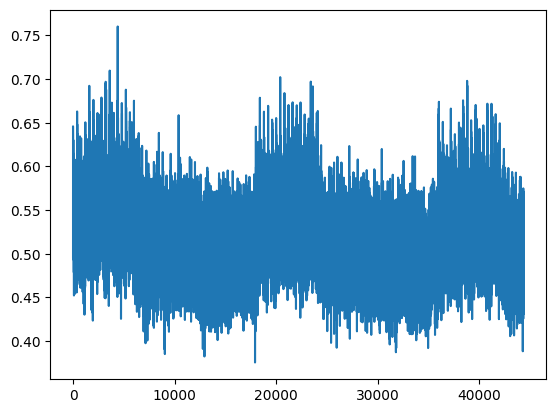

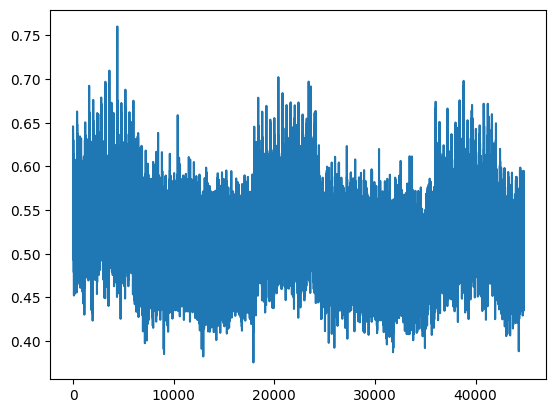

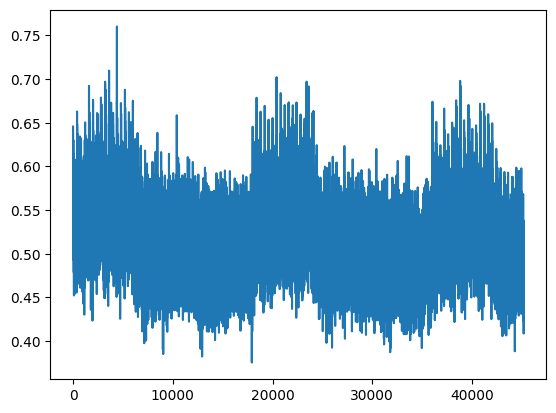

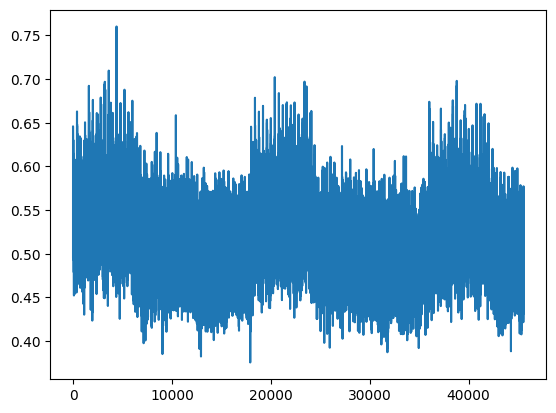

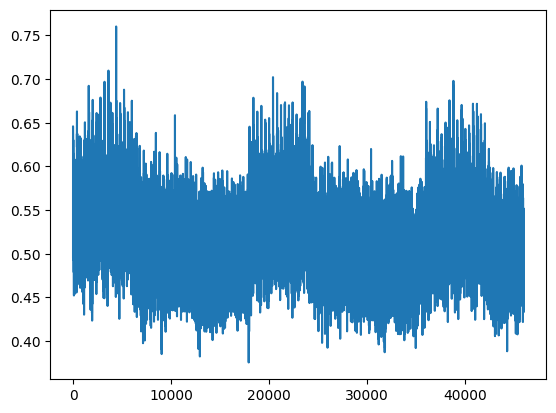

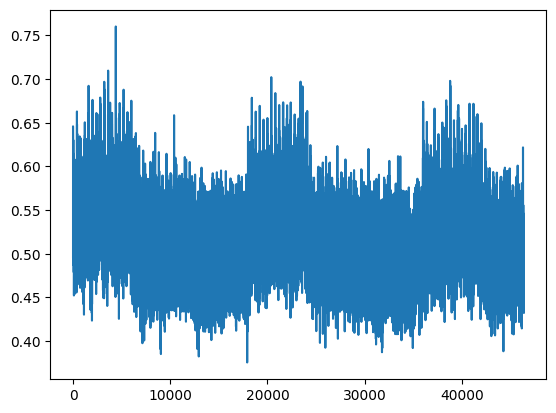

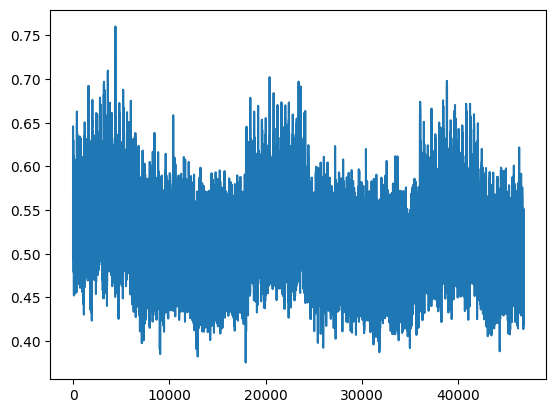

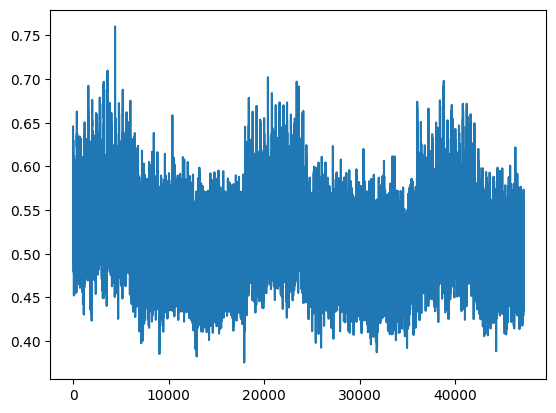

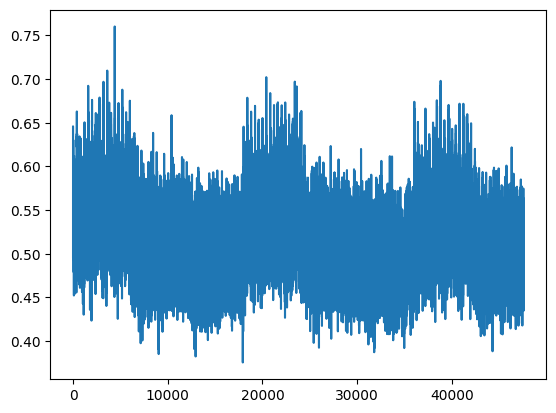

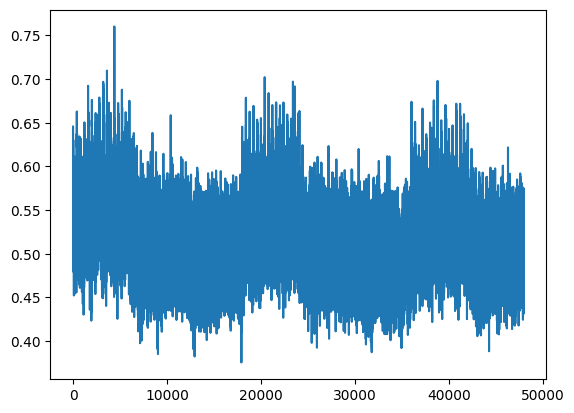

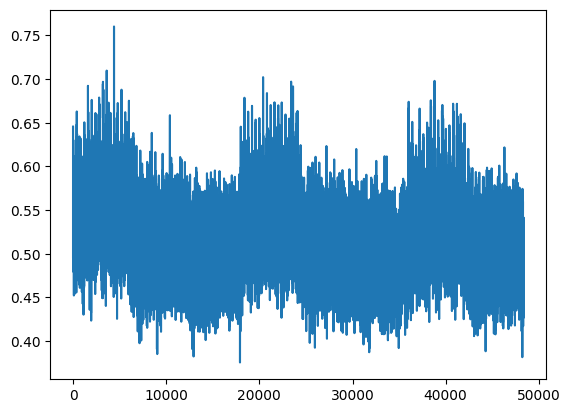

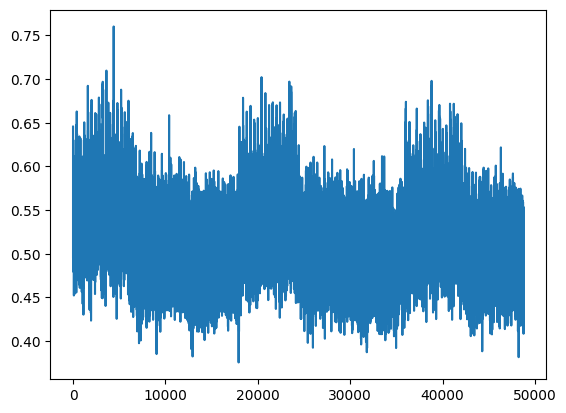

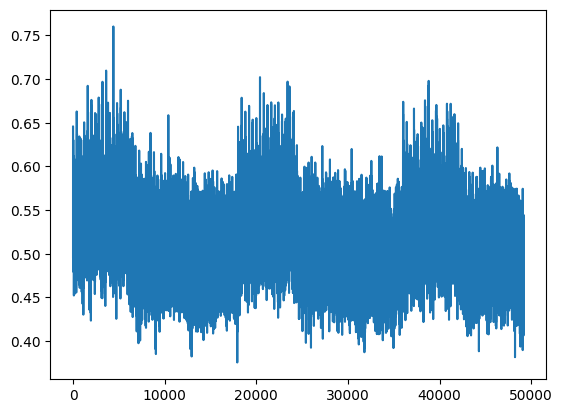

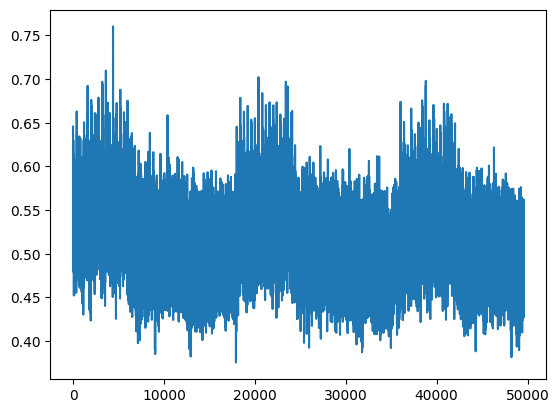

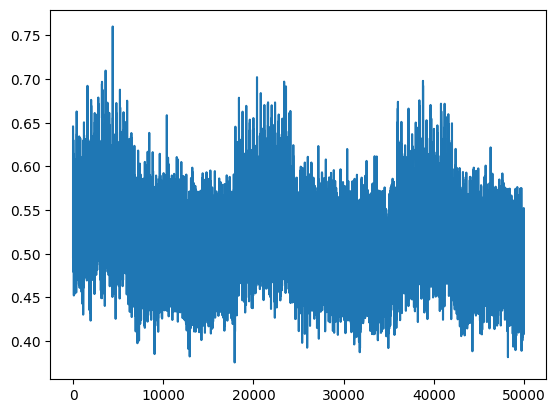

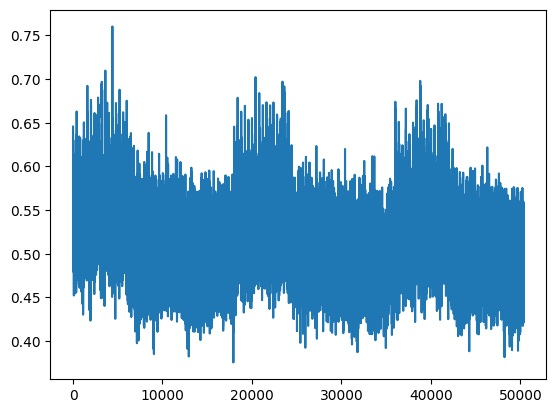

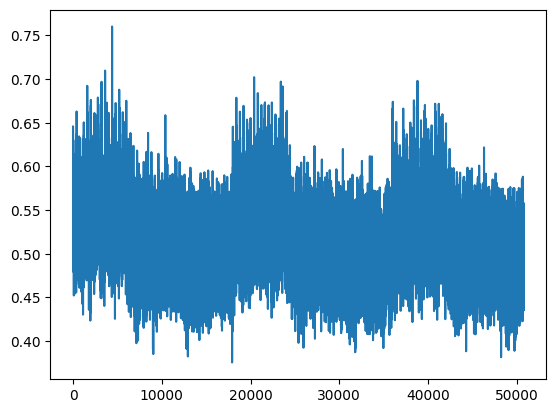

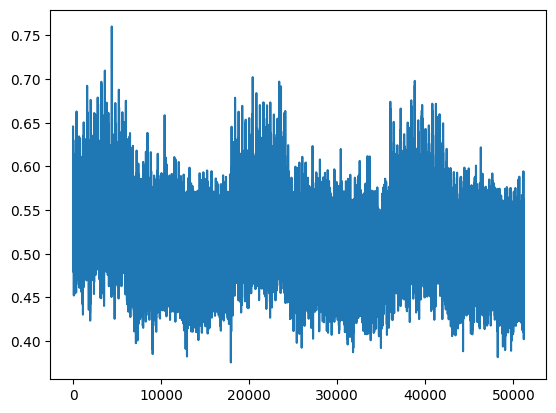

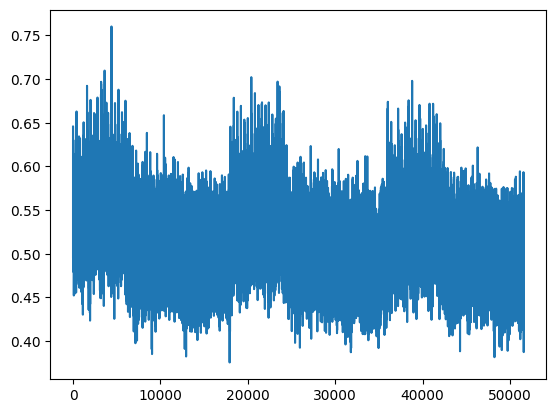

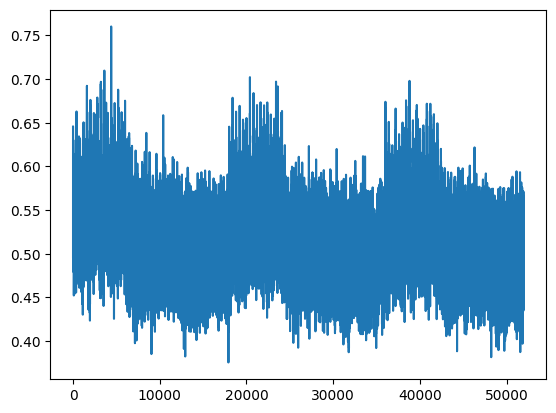

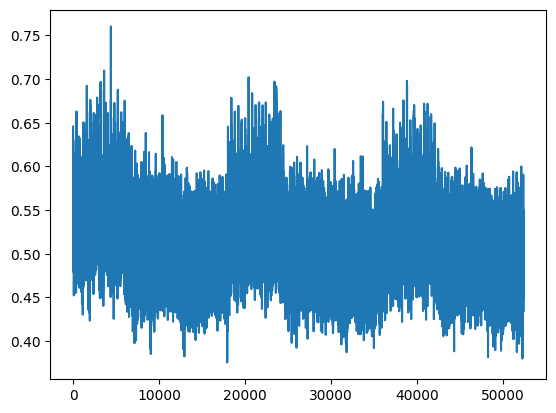

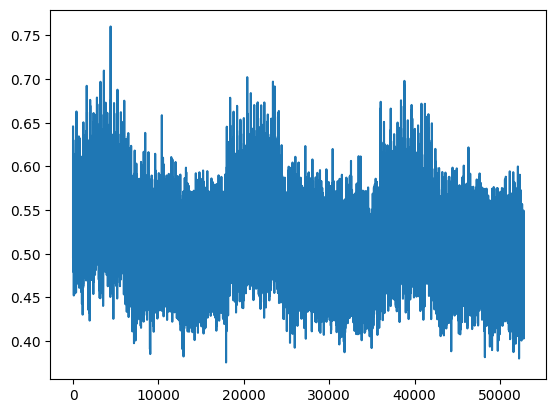

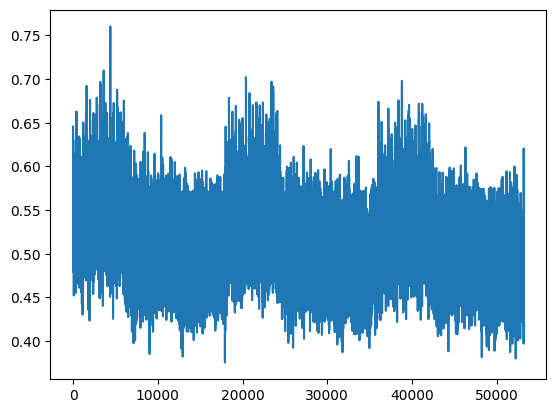

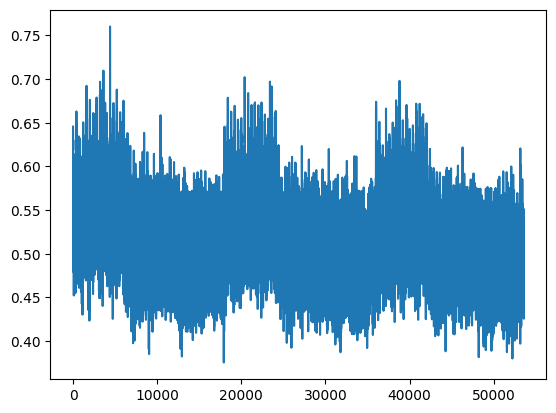

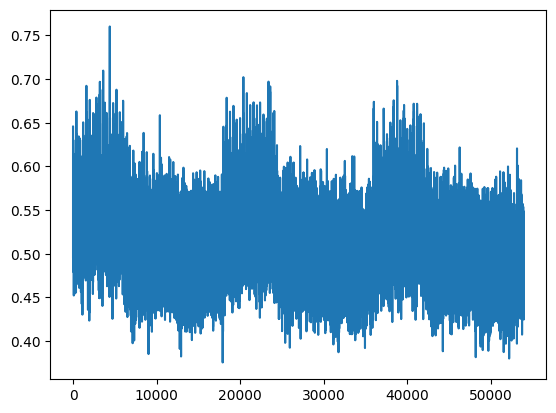

In [9]:
### Train the network on various saved games:    
load_dir = os.path.join(Path.cwd(), 'saved_games', 'v4', 'train')
save_paths = os.listdir(load_dir)

### Training parameters:
is_augment = True
epoch_list = [400, 400, 400]
batch_size_list = [512, 512, 512]
is_include_policy = True
is_plot_losses = False
learning_rate_list = [2e-3, 6e-4, 2e-4]   # [2e-3, 1e-3, 3e-4]
iterations = 3

### Iterate over all data sets:
for _ in range(iterations):
    for _epoch, _bsize, _lr in zip(epoch_list, batch_size_list, learning_rate_list):
        print(f"\n{_epoch=}, {_bsize=}, {_lr=}\n")
        
        for _path in save_paths:
            print(_path)
            
            data_location = os.path.join(load_dir, _path)
            
            my_trainer.train(data_location=data_location,
                             is_augment=is_augment,
                             epochs=_epoch,
                             batch_size=_bsize,
                             is_include_policy=is_include_policy,
                             is_plot_losses=is_plot_losses,
                             learning_rate=_lr,
                             is_mask_policy=False,
                            )
            
            fig, ax = plt.subplots()
            ax.plot(my_trainer.losses)
    
    ### Save the network after training iterations finish:
    save_string = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
    save_path = os.path.join(Path.cwd(), 'saved_networks', 'v4', save_string + '.pt')
    torch.save(my_network.state_dict(), save_path)

In [ ]:
#okay so our next to do is:
# 1. sort out the data loader perhaps
# 2. discover where it is failing and maybe try and correct for that, decide next steps etc.
# 3. start running actual games with actual exploration, 2 moves from the win for example.
        # and make sure this actually works
# 4. 

In [ ]:
### Train the network on various saved games:    
load_dir = os.path.join(Path.cwd(), 'saved_games', 'v4', 'train')
save_paths = os.listdir(load_dir)

### Training parameters:
is_augment = True
epoch_list = [300, 300, 300]
batch_size_list = [512, 512, 512]
is_include_policy = True
is_plot_losses = False
learning_rate_list = [1e-3, 5e-4, 1e-5]

### Iterate over all data sets:
for _ in range(3):
    for _epoch, _bsize, _lr in zip(epoch_list, batch_size_list, learning_rate_list):
        print(f"\n{_epoch=}, {_bsize=}, {_lr=}\n")
        
        for _path in save_paths:
            print(_path)
            
            data_location = os.path.join(load_dir, _path)
            
            my_trainer.train(data_location=data_location,
                             is_augment=is_augment,
                             epochs=_epoch,
                             batch_size=_bsize,
                             is_include_policy=is_include_policy,
                             is_plot_losses=is_plot_losses,
                             learning_rate=_lr,
                             is_mask_policy=False,
                            )
            
            fig, ax = plt.subplots()
            ax.plot(my_trainer.losses)
    
    ### Save the network after training iterations finish:
    save_string = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
    save_path = os.path.join(Path.cwd(), 'saved_networks', 'v3', save_string + '.pt')
    torch.save(my_network.state_dict(), save_path)

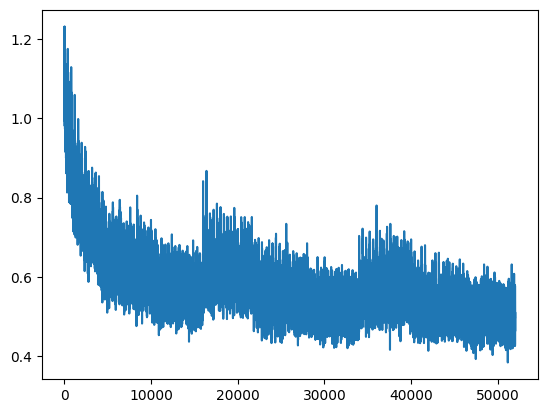

In [4]:
fig, ax = plt.subplots()
ax.plot(my_trainer.losses[2000:])

In [ ]:
### load a network and assess the accuracy

# save location for the state dictionary:
npaths = ["2025_07_02_17_49",
          "2025_07_02_19_04",
          "2025_07_03_12_18",
          "2025_07_03_13_28",
          "2025_07_03_15_17",
          "2025_07_03_16_37",
          "2025_07_03_17_44",
          "2025_07_03_21_08",
          "2025_07_03_22_57",
          "2025_07_04_13_54"
         ]

# todo need some way to get the meta characteristics in a file so that can always be loaded if the 
# architecture changes:

# path locations:
nlocs = [os.path.join(Path.cwd(), 'saved_networks', network_path + '.pt') for network_path in npaths]

# create shell networks:
nets = [PatternsNet(in_channels=47, out_channels=128) for _ in npaths]

# populate each network with different saved instance:
for _net, _nloc in zip(nets, nlocs):
    _net.load_state_dict(torch.load(_nloc, weights_only=True))

# assign to trainer class: (do we want to avoid assigning the network?)
ts = [PatternTrainer(network=_net, device=my_device) for _net in nets]

# string and data path for the validation games:
valid_path = "VALID_2025_07_02_07_57.pkl"
dloc = os.path.join(Path.cwd(), 'saved_games', valid_path)

# assess the losses for the network in question:
for _t in ts:
    _win_acc, _loss_acc, _draw_acc = _t.validate_value(data_location=dloc,
                                                       num_check=2000,
                                                       is_augment=True,
                                                       is_plot=True)
    
    print(_win_acc, _loss_acc, _draw_acc)


In [ ]:
fig, ax = plt.subplots()
ax.plot(my_trainer.losses)

In [ ]:
fig, ax = plt.subplots()
ax.set_ylim([0., 0.55])
ax.plot(my_trainer.losses)

In [ ]:
load_strings = ["2025_06_05_09_26", "2025_06_05_14_15", "2025_06_05_19_20"]

network_load_locations = [os.path.join(Path.cwd(), 'saved_networks', _ls + '.pt') for _ls in load_strings]

nets = [PatternsNet(in_channels=103, out_channels=128) for _ in range(len(load_strings))]

for net, load_location in zip(nets, network_load_locations):
    net.load_state_dict(torch.load(load_location, weights_only=True))

validation_data_location = os.path.join(Path.cwd(), 'saved_games', '2025_05_30_11_27.pkl')

vtrainers = [PatternTrainer(network=_net, device=my_device) for _net in nets]